In [290]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sktime.transformations.series.impute import Imputer

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold, cross_val_score

import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
train = pd.read_csv('train.csv')

In [453]:
test = pd.read_csv('test_2.csv')

In [8]:
def display_all_columns(df: pd.DataFrame):
    with pd.option_context('display.max_columns', None):
        display(df)

In [10]:
train.head()

Id  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   1        NaN        NaN        NaN        NaN        8.0        NaN   
1   2        NaN        NaN        NaN        NaN        3.0   0.388896   
2   3        NaN  -0.696727   0.739591  -0.167928        9.0   0.471947   
3   4        NaN  -0.694350   1.568248   0.479073        5.0   0.120653   
4   5        6.0  -1.736489   2.765531   1.245280        7.0   4.866985   

   Feature_7  Feature_8  Feature_9  ...   Ret_175   Ret_176   Ret_177  \
0      75751     0.2254       11.0  ... -0.002688  0.002246 -0.000838   
1      17369     0.0166       13.0  ... -0.000129  0.000123  0.000248   
2       8277     0.3650        9.0  ... -0.000524 -0.000394  0.000116   
3      22508     0.2654       13.0  ...  0.000346 -0.000090  0.000288   
4      22423     0.2138       13.0  ... -0.001235  0.000027  0.002449   

        Ret_178   Ret_179   Ret_180  Ret_PlusOne  Ret_PlusTwo  \
0 -6.953224e-04  0.000003 -0.001974    -0.019512     0.028846   
1  3.315418e-07  0.000003  0.000027    -0.002939    -0.010253   
2  5.322557e-04  0.000274  0.000784    -0.024791     0.015711   
3 -1.281102e-04  0.000074  0.000341    -0.005680    -0.002190   
4  8.619882e-06  0.001209 -0.000004     0.036104    -0.026552   

   Weight_Intraday  Weight_Daily  
0     1.251508e+06  1.564385e+06  
1     1.733950e+06  2.167438e+06  
2     1.529197e+06  1.911497e+06  
3     1.711569e+06  2.139462e+06  
4     1.267270e+06  1.584088e+06  

[5 rows x 211 columns]

In [12]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 211 columns):
 #    Column           Dtype  
---   ------           -----  
 0    Id               int64  
 1    Feature_1        float64
 2    Feature_2        float64
 3    Feature_3        float64
 4    Feature_4        float64
 5    Feature_5        float64
 6    Feature_6        float64
 7    Feature_7        int64  
 8    Feature_8        float64
 9    Feature_9        float64
 10   Feature_10       float64
 11   Feature_11       float64
 12   Feature_12       float64
 13   Feature_13       float64
 14   Feature_14       float64
 15   Feature_15       float64
 16   Feature_16       float64
 17   Feature_17       float64
 18   Feature_18       float64
 19   Feature_19       float64
 20   Feature_20       float64
 21   Feature_21       float64
 22   Feature_22       float64
 23   Feature_23       float64
 24   Feature_24       float64
 25   Feature_25       float64
 26   Ret_MinusTwo    

**Table of Content**


Loading the dataset
Feature/Data Exploration
Data Preprocessing and Cleaning
Modelling
Evaluation
Error Analysis


In [15]:
df = train.copy()

Top Features with the Most Missing Values

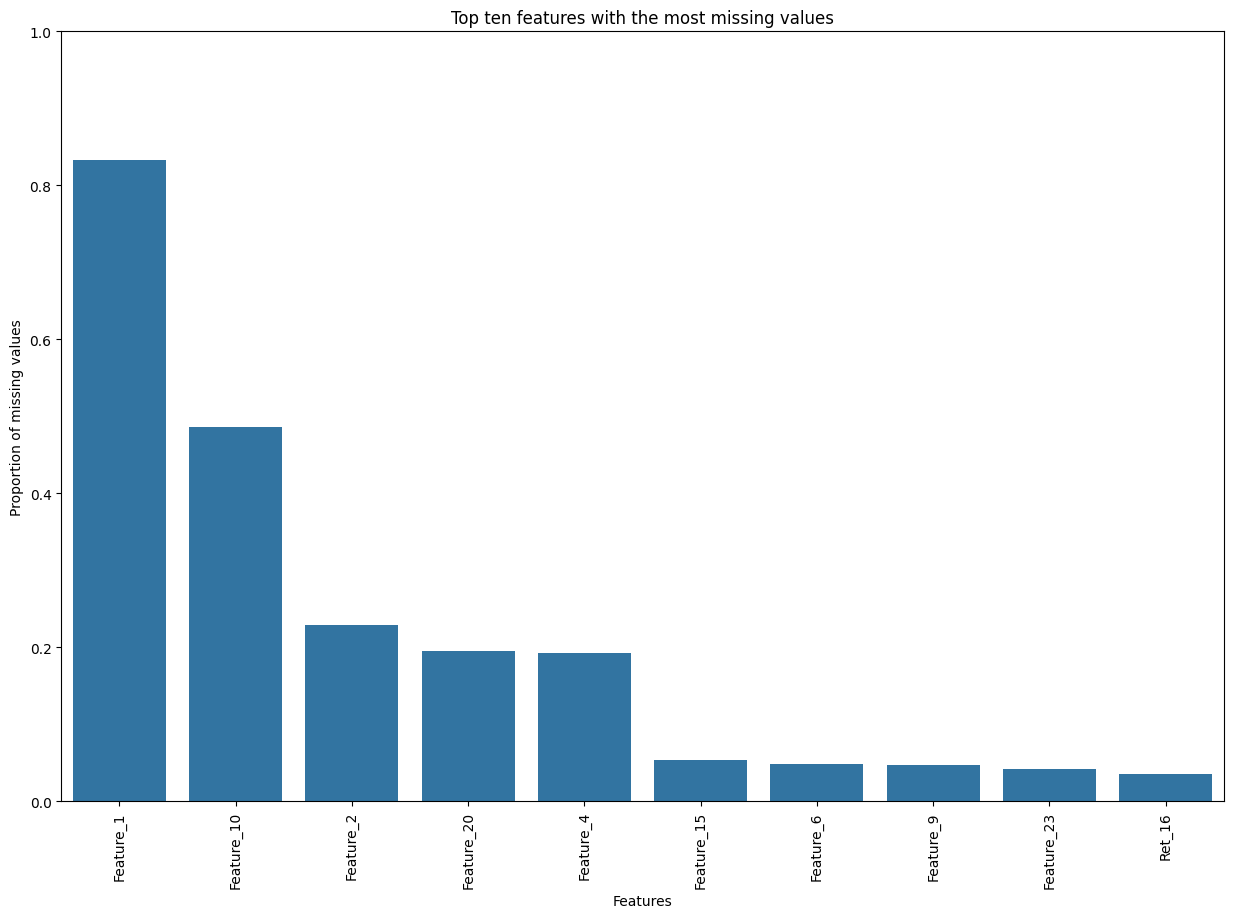

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
df_na = (df.isnull().sum()/len(df))
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:10]
sns.barplot(x=df_na.index, y=df_na)
plt.xticks(range(df_na.size), df_na.index, rotation=90)
plt.ylim([0,1])
plt.title('Top ten features with the most missing values')
plt.ylabel('Proportion of missing values')
plt.xlabel('Features')
plt.show()

Top Features with the Least Missing Values

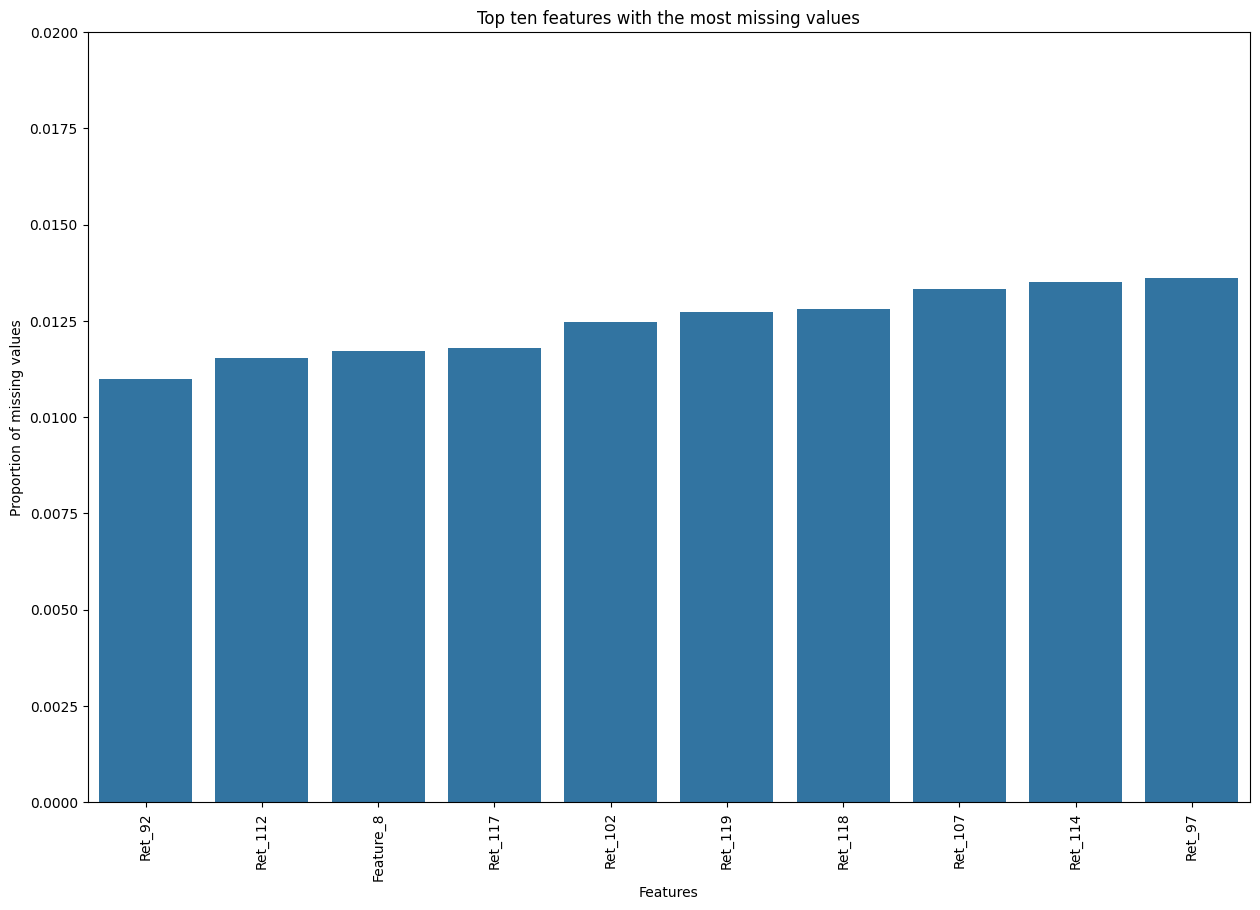

In [21]:
fig, ax = plt.subplots(figsize=(15,10))
df_na = (df.isnull().sum()/len(df))
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=True)[:10]
sns.barplot(x=df_na.index, y=df_na)
plt.xticks(range(df_na.size), df_na.index, rotation=90)
plt.ylim([0,0.02])
plt.title('Top ten features with the most missing values')
plt.ylabel('Proportion of missing values')
plt.xlabel('Features')
plt.show()

In [23]:
feature_cols = [f"Feature_{i}" for i in range(1, 26)]
intra_ret_feat_cols = [f"Ret_{i}" for i in range(2, 121)]
intra_ret_target_cols = [f"Ret_{i}" for i in range(121, 181)]
intra_ret_cols = intra_ret_feat_cols + intra_ret_target_cols
inter_ret_feat_cols = ["Ret_MinusTwo", "Ret_MinusOne"]
inter_ret_target_cols = ["Ret_PlusOne", "Ret_PlusTwo"]
inter_ret_cols = inter_ret_feat_cols + inter_ret_target_cols

Text(0.5, 1.0, 'Correlation Matrix of Features')

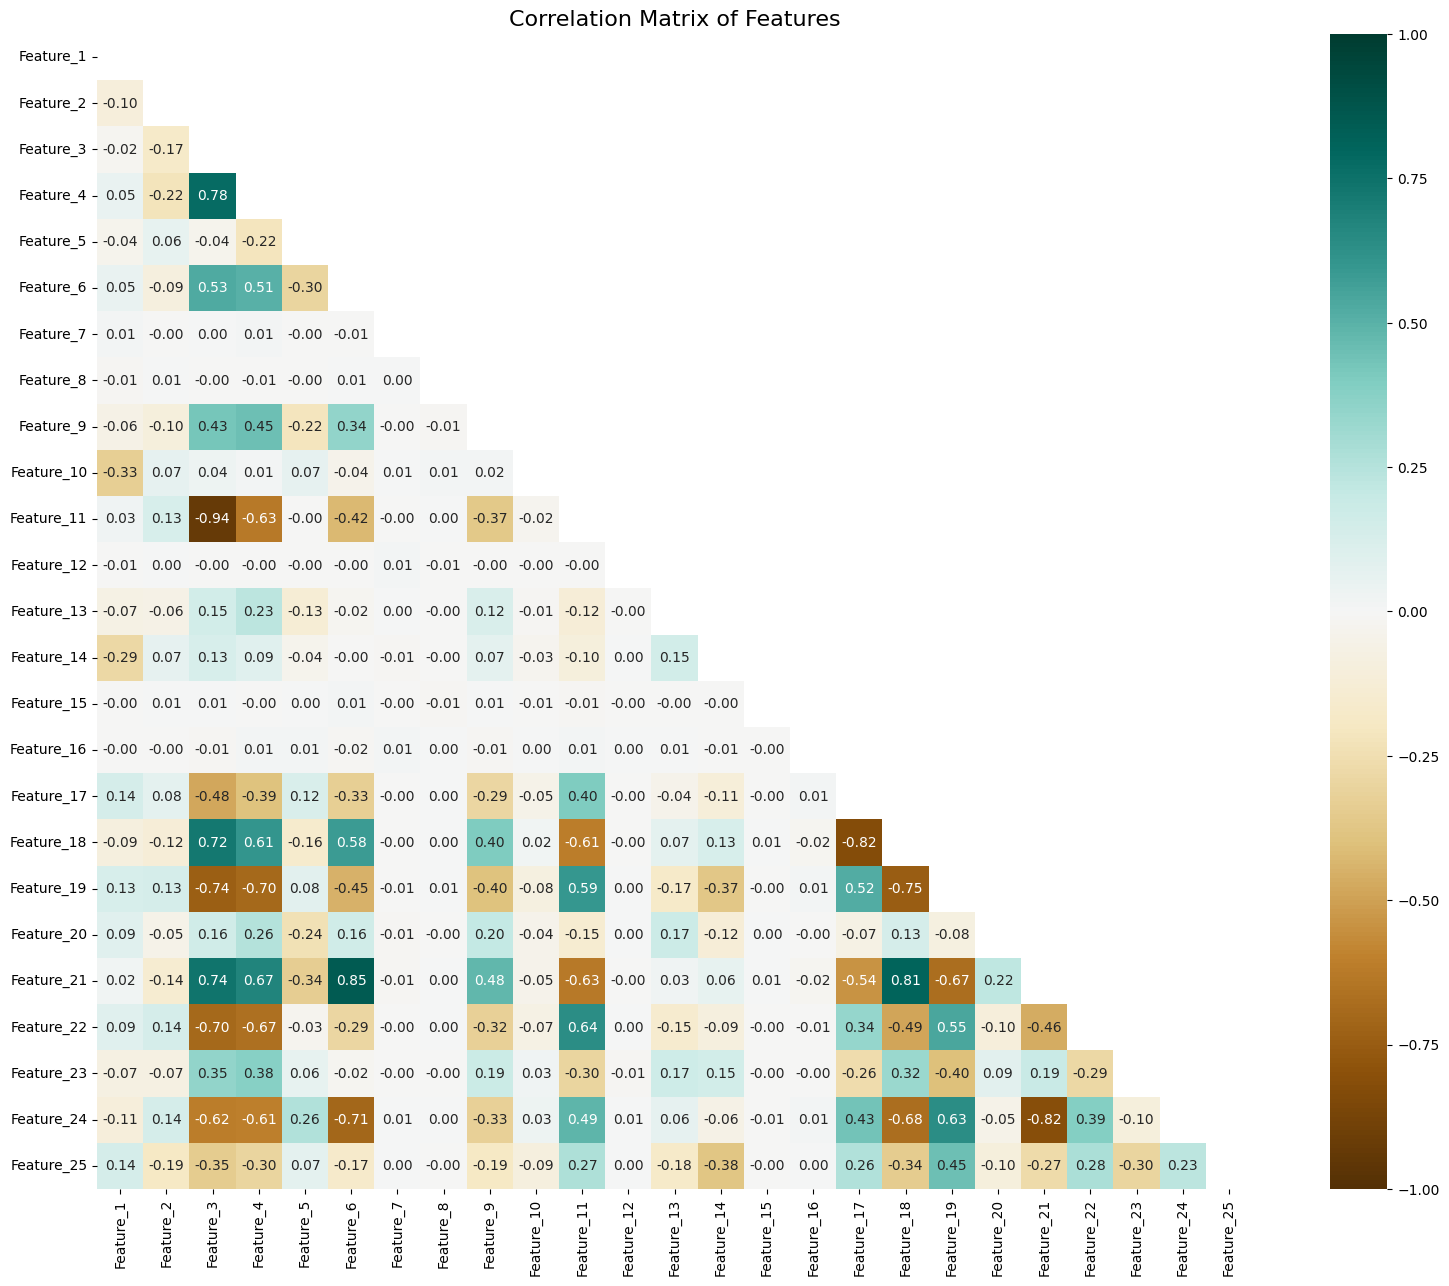

In [25]:
feature_correlations = df[feature_cols].corr()
mask = np.triu(np.ones_like(feature_correlations, dtype=bool))
fig, ax = plt.subplots(1,1, figsize=(20,15))
ax = sns.heatmap(feature_correlations, mask=mask, annot=True, vmax=1, vmin=-1, cmap='BrBG', square=True, fmt='.2f', edgecolor='black')
ax.set_title('Correlation Matrix of Features', fontdict ={'fontsize':16})

Identifying Top Features Relevant to Target Features

In [27]:
target_features = intra_ret_target_cols + inter_ret_target_cols

Inter Day Correlations

In [31]:
inter_ret_target_cols

['Ret_PlusOne', 'Ret_PlusTwo']

In [33]:
inter_correlations_1 = df[feature_cols + inter_ret_target_cols].corr().drop(inter_ret_target_cols)
inter_top_features_1 = inter_correlations_1.abs().sort_values(by=inter_ret_target_cols, ascending=False).index[:10]

In [35]:
inter_top_features_1

Index(['Feature_1', 'Feature_6', 'Feature_24', 'Feature_3', 'Feature_20',
       'Feature_21', 'Feature_11', 'Feature_25', 'Feature_18', 'Feature_9'],
      dtype='object')

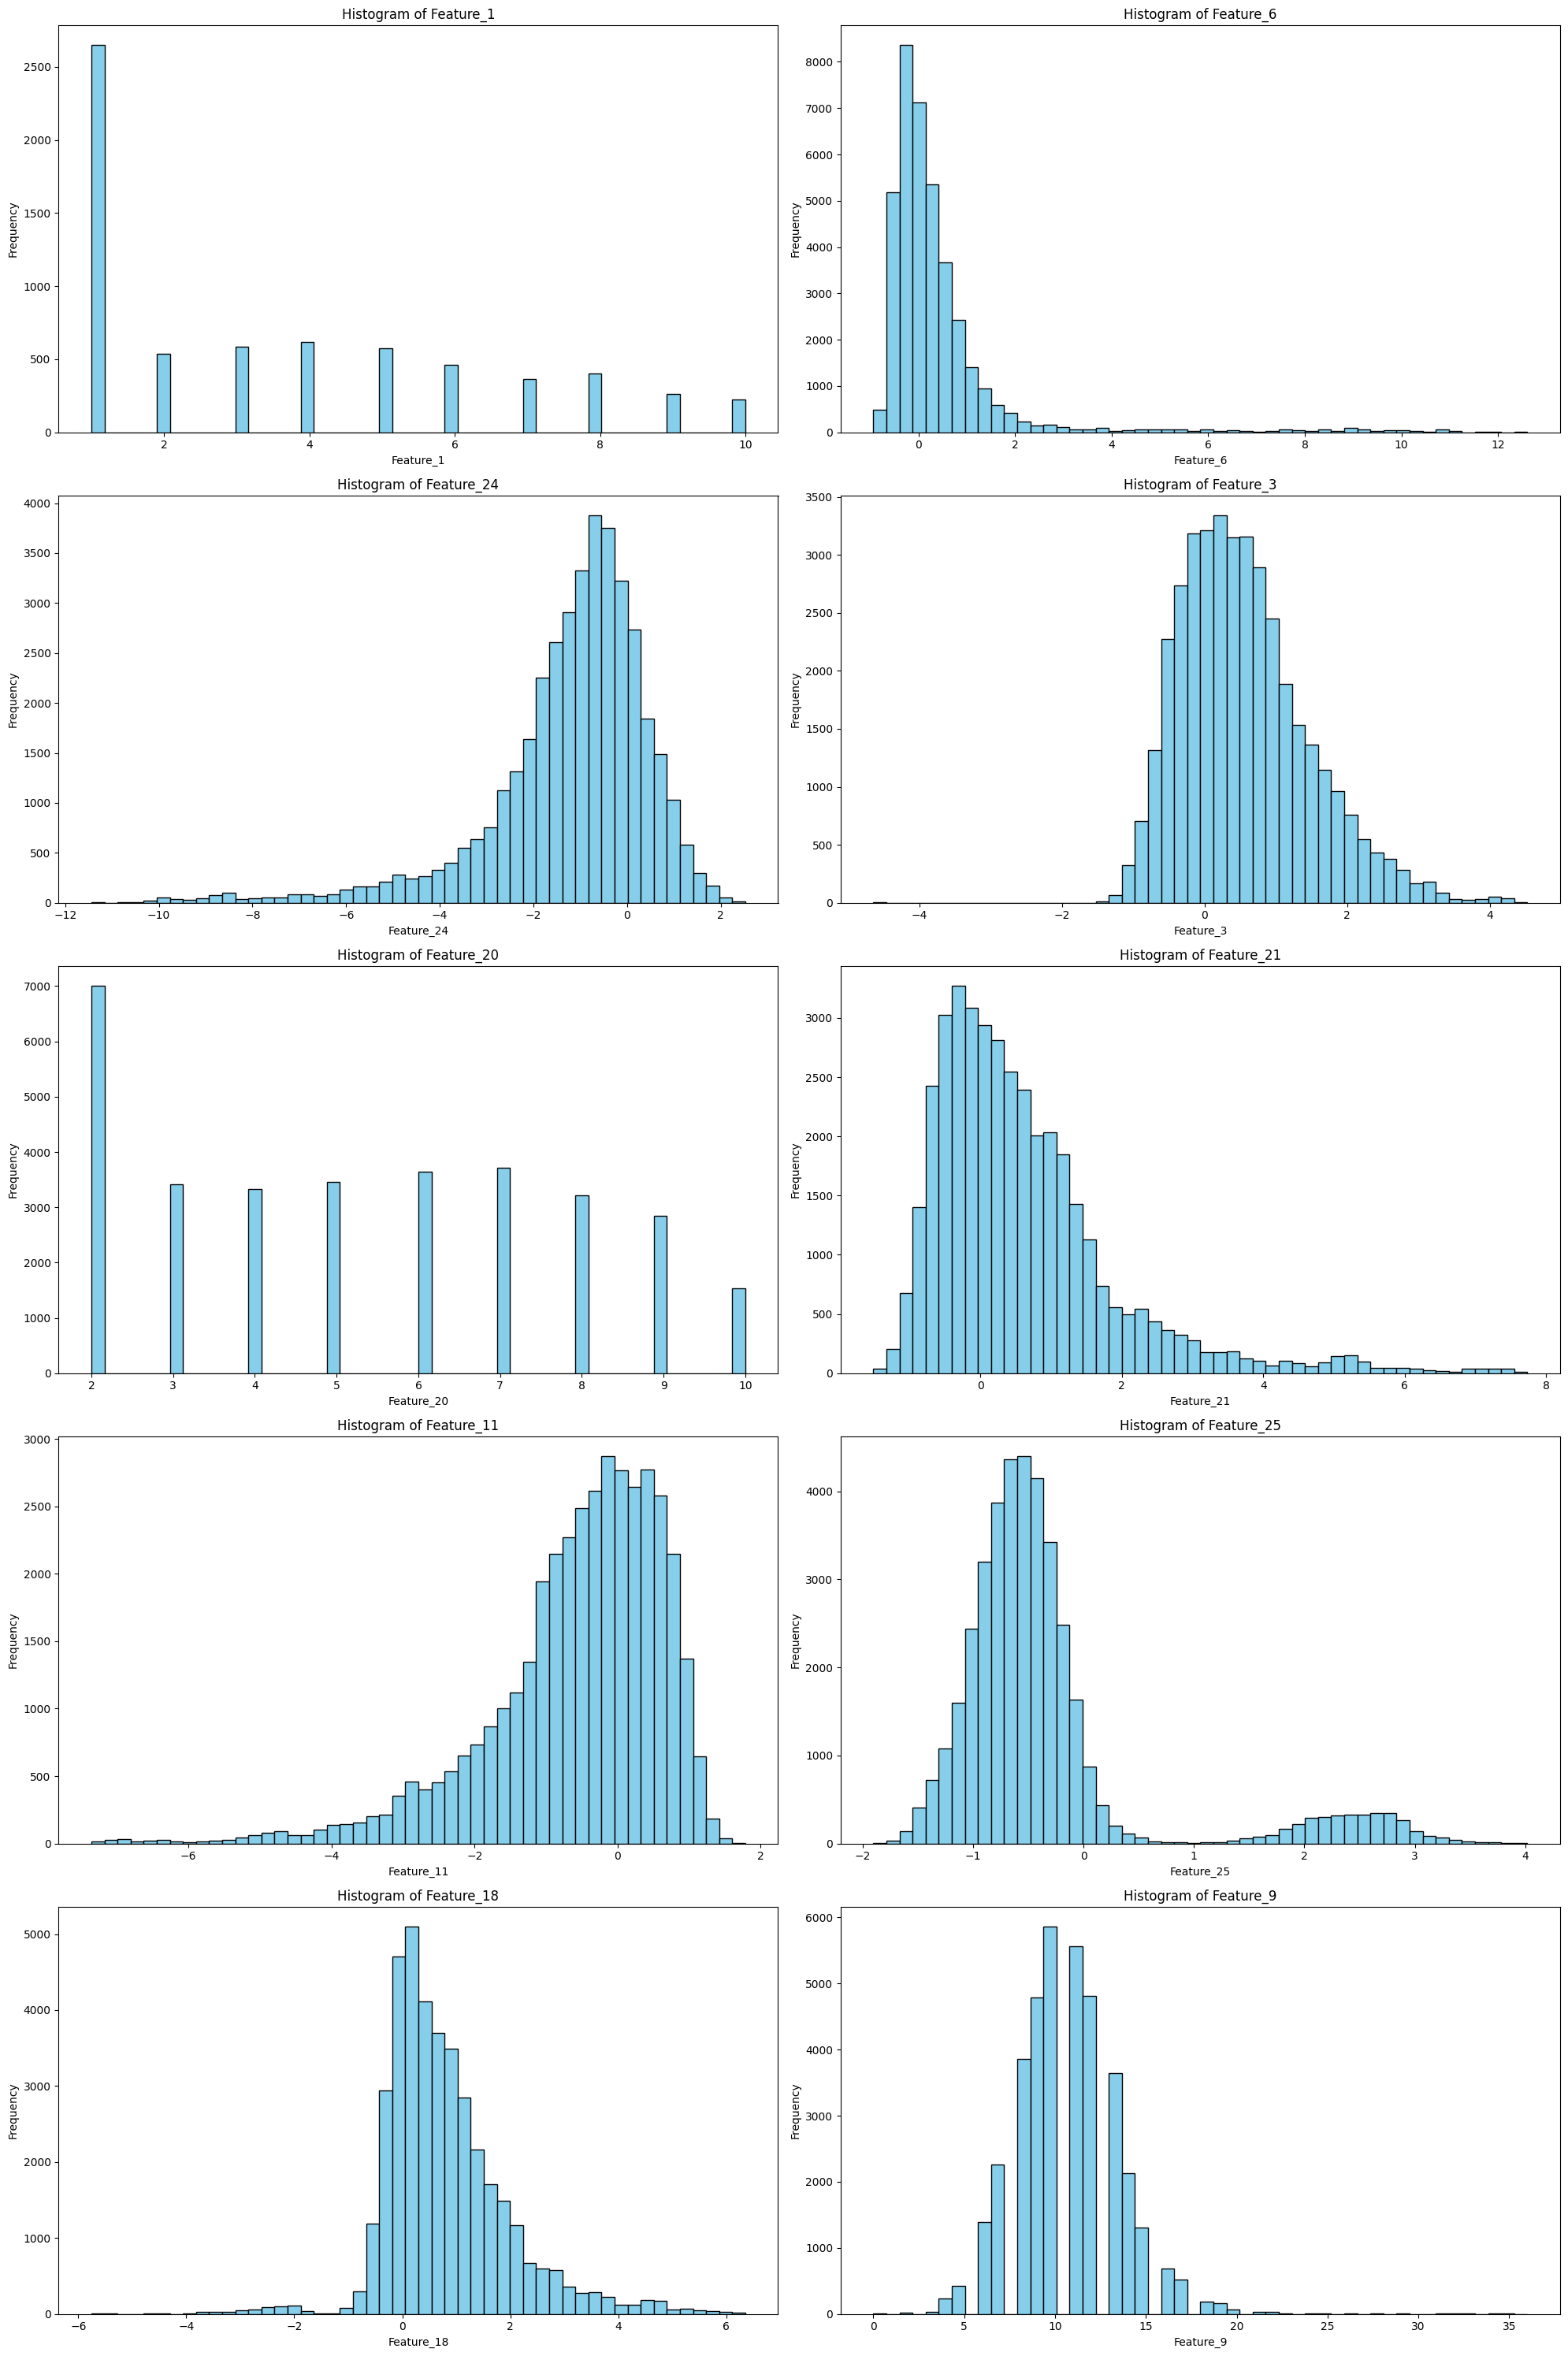

In [37]:
n_cols = 2
n_rows = 5

fig = plt.figure(figsize=(20, 30))
gs = GridSpec(n_rows, n_cols)

for idx, feature in enumerate(inter_top_features_1):
  ax = fig.add_subplot(gs[idx])
  ax.hist(df[feature].dropna(), bins=50, color='skyblue', edgecolor='black')
  ax.set_title(f'Histogram of {feature}')
  ax.set_xlabel(feature)
  ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**Key Features Comparism Against Interday Returns**

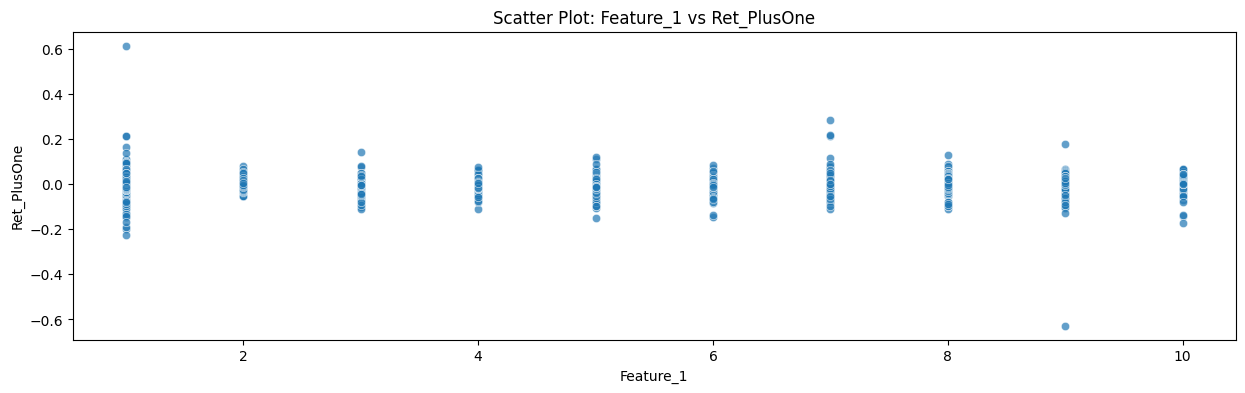

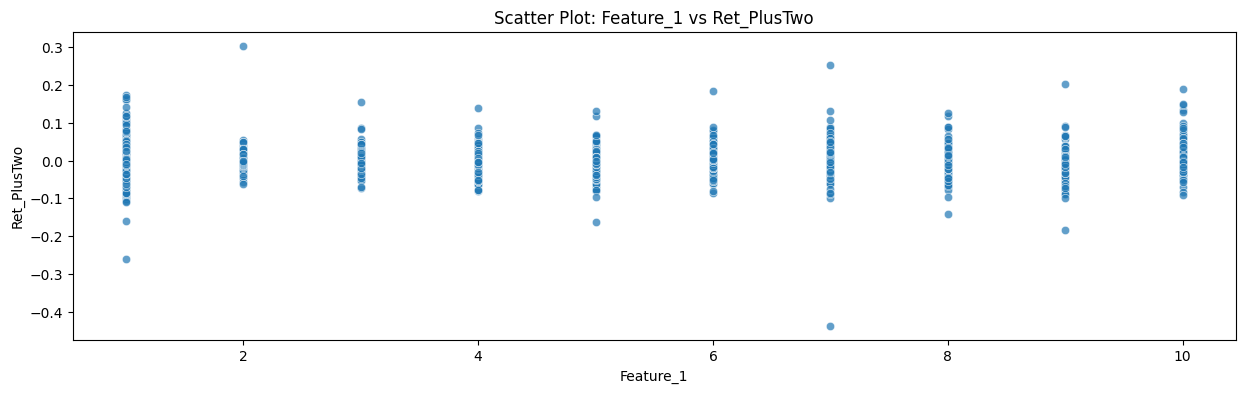

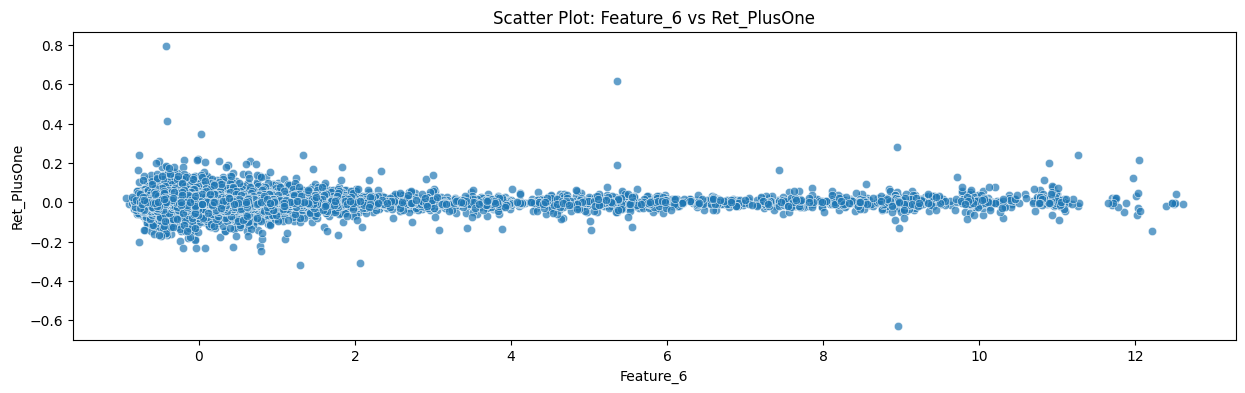

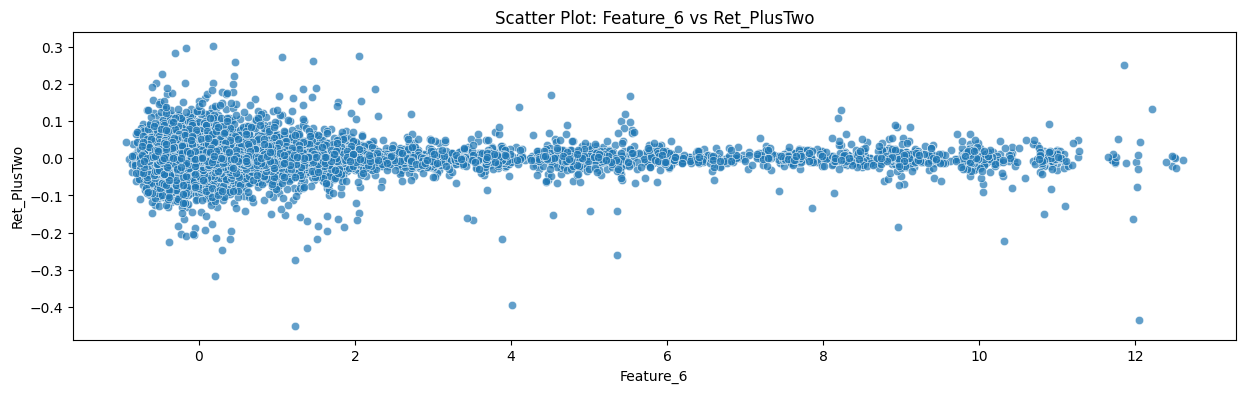

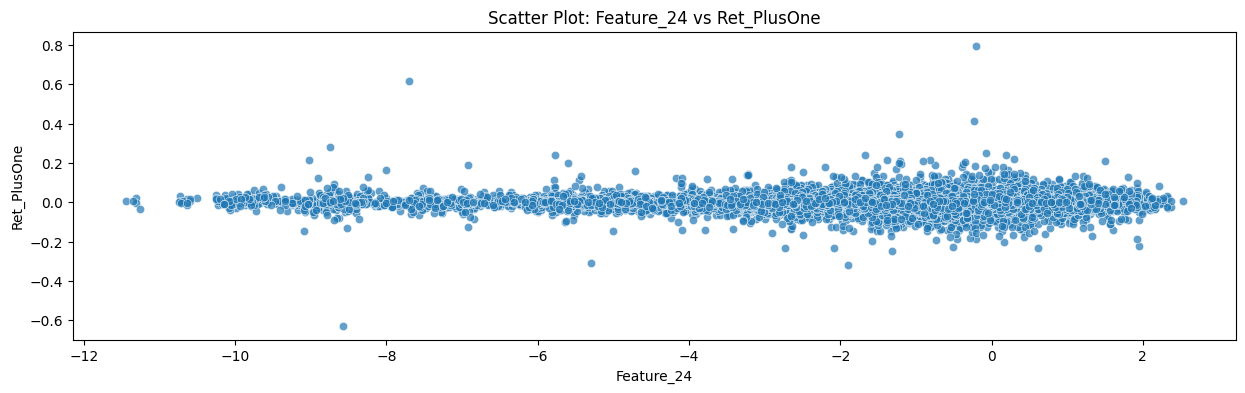

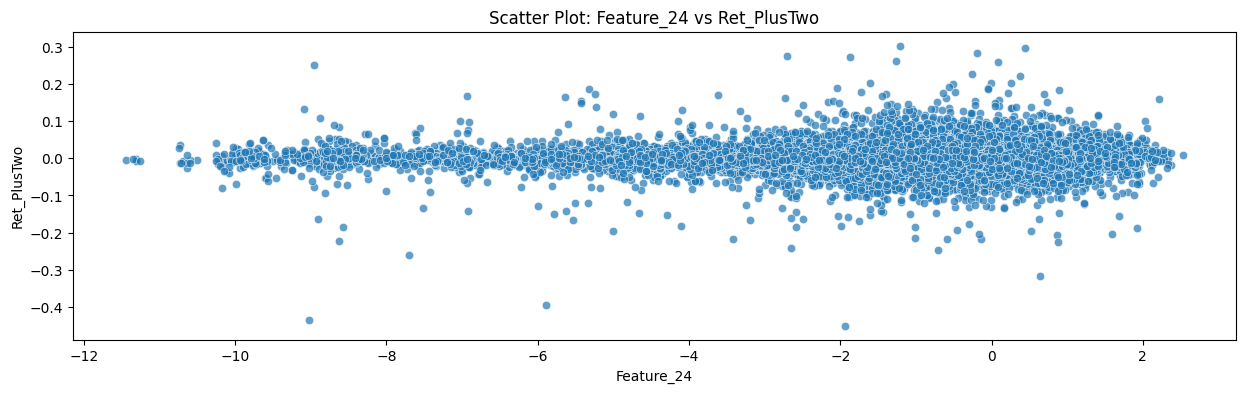

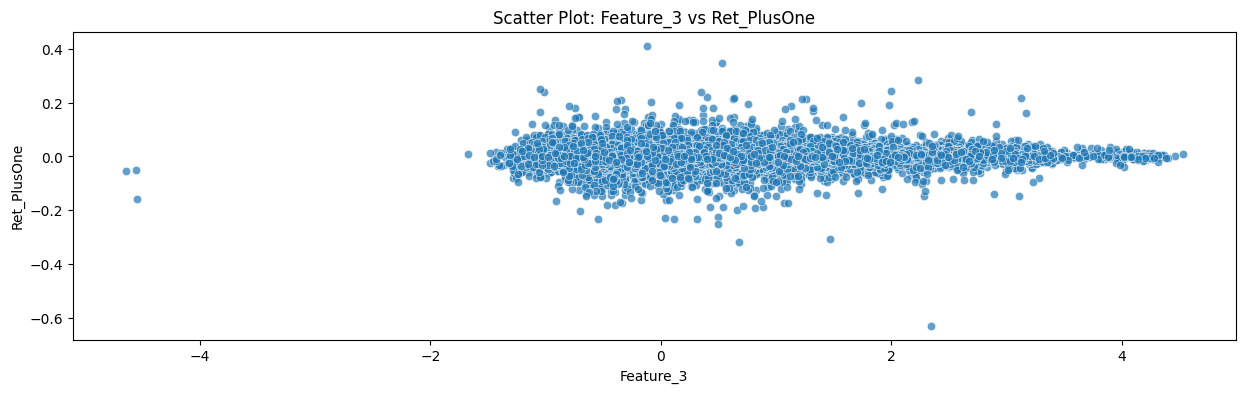

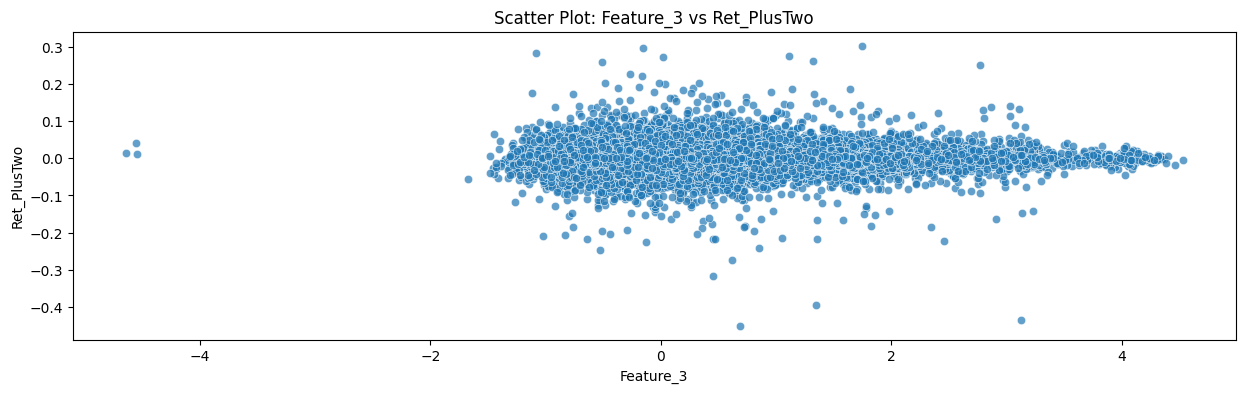

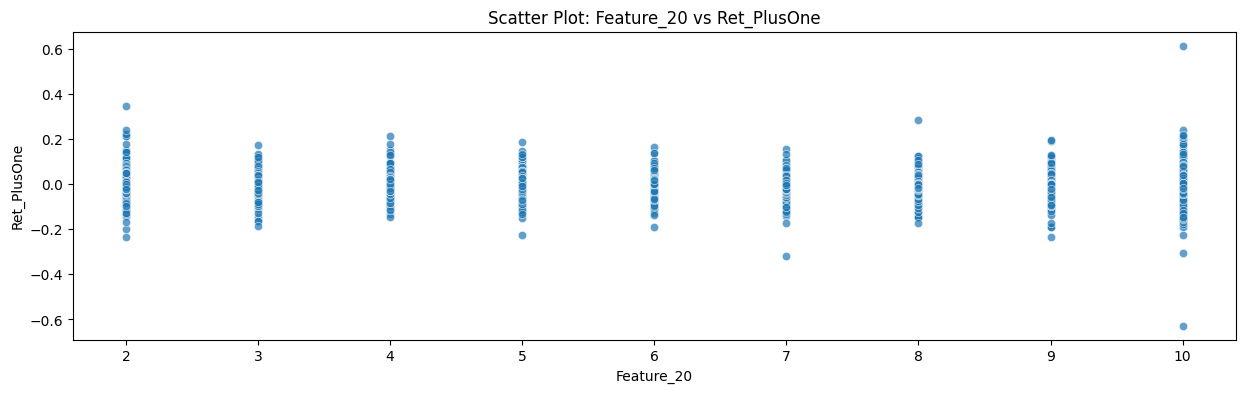

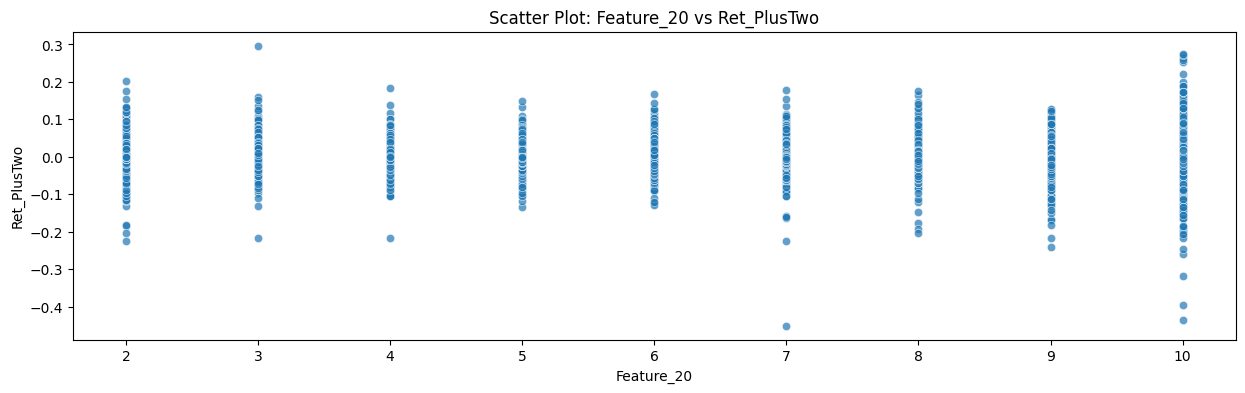

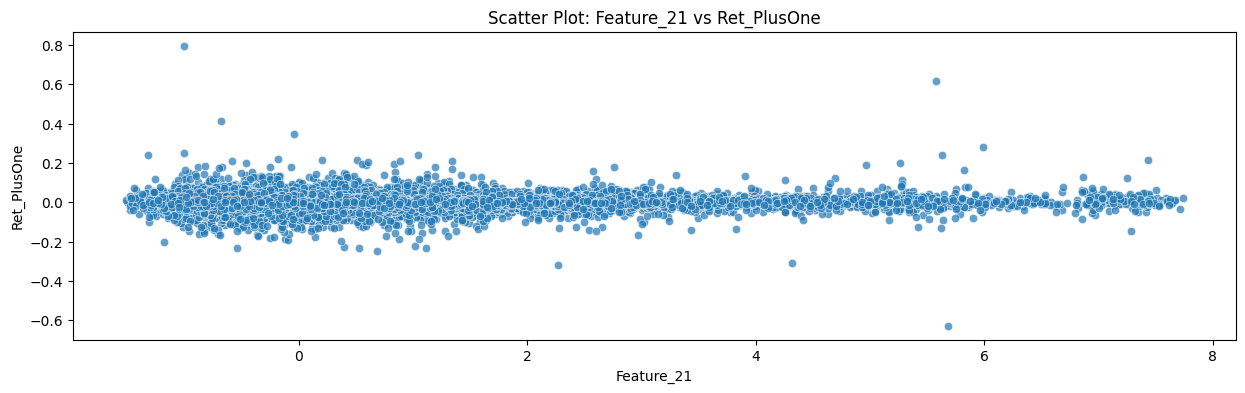

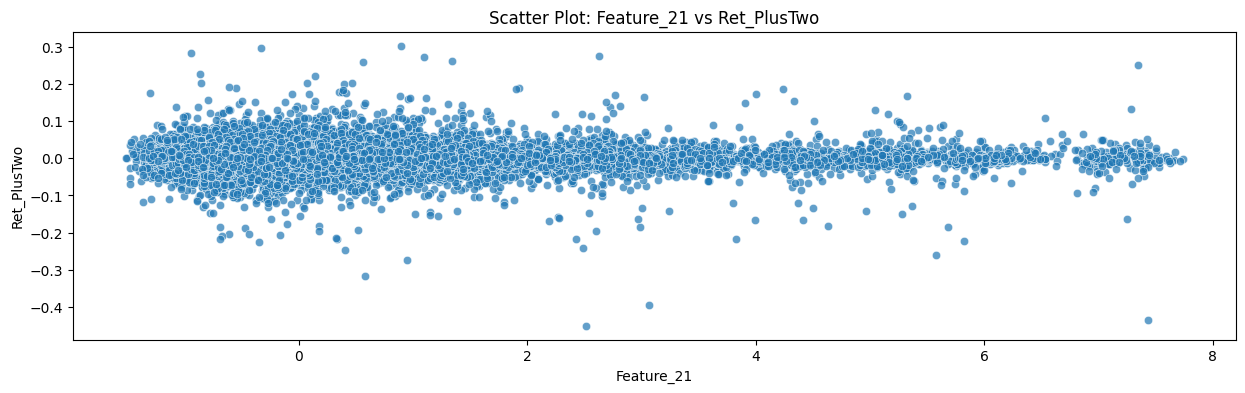

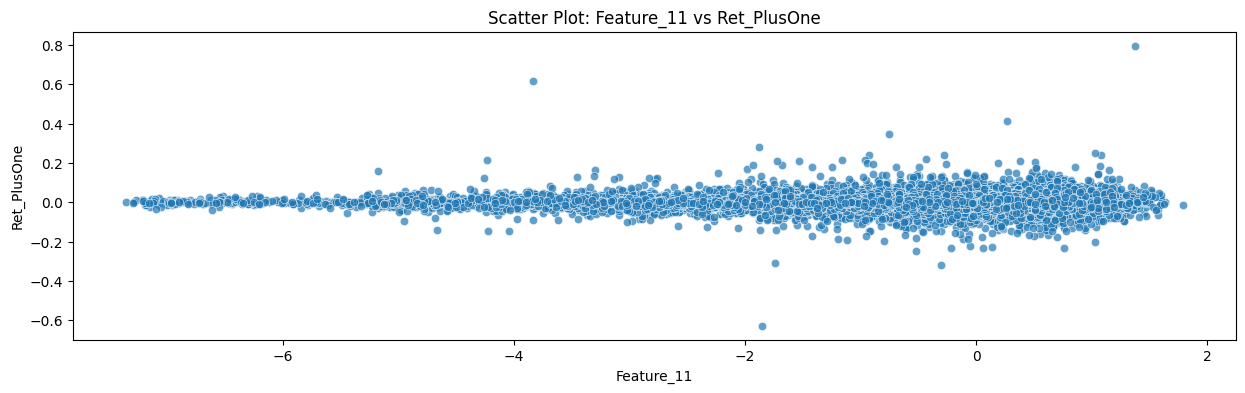

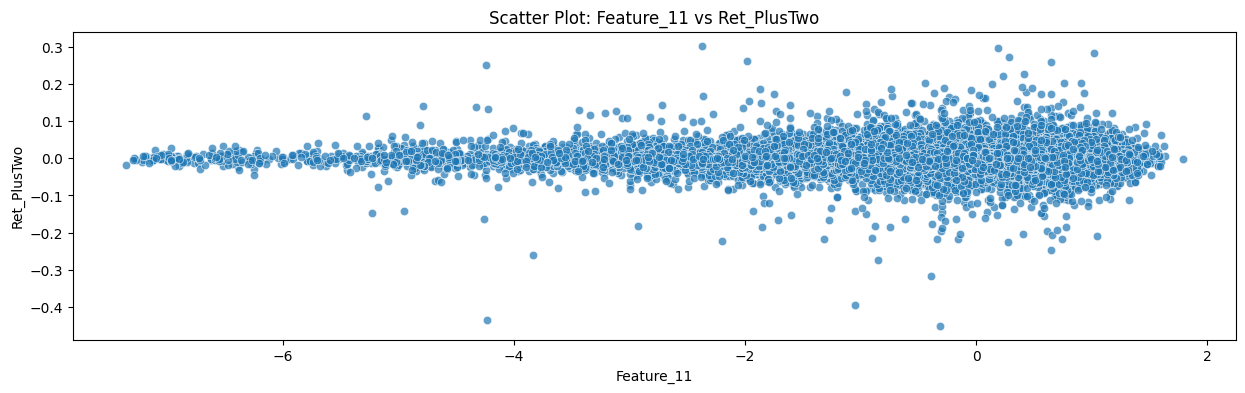

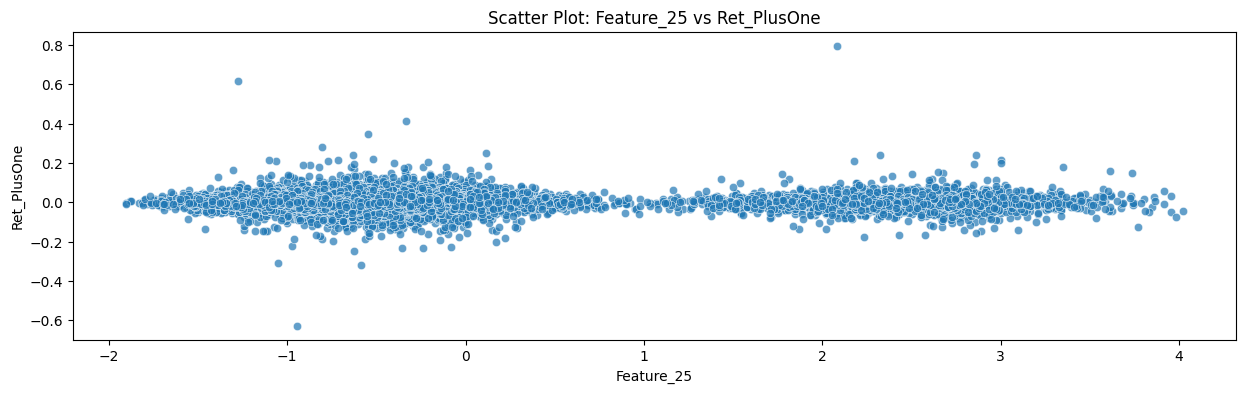

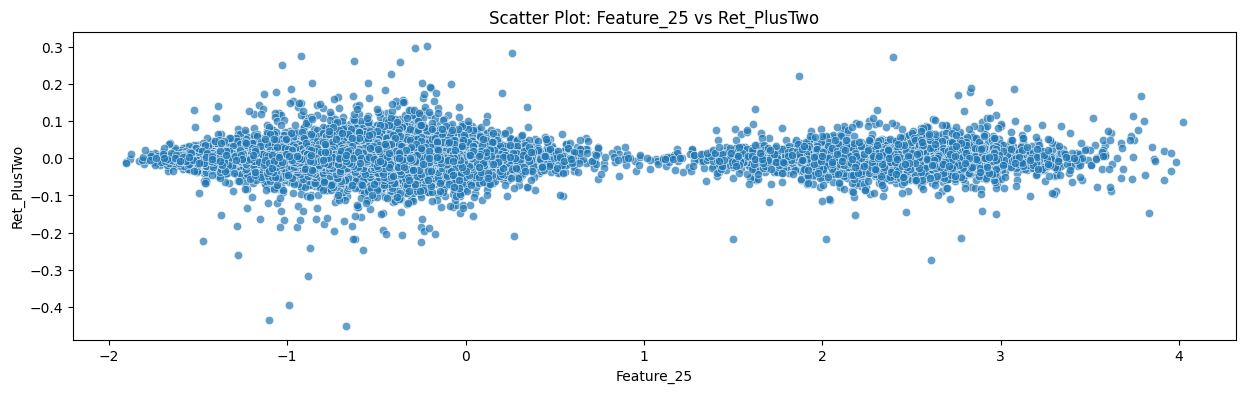

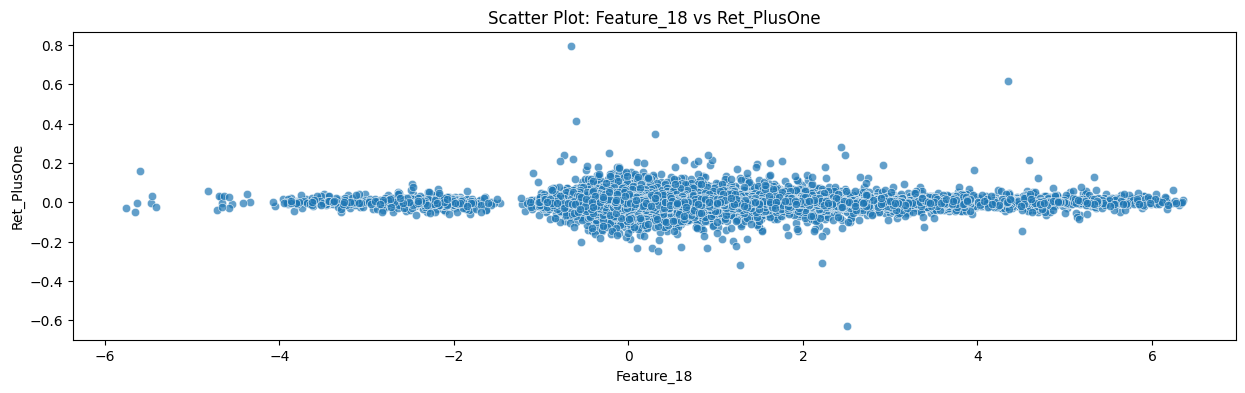

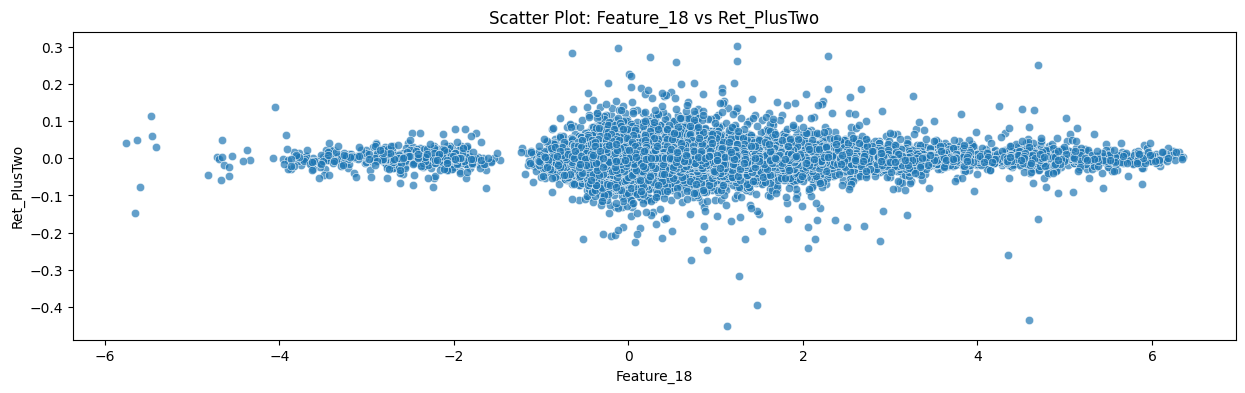

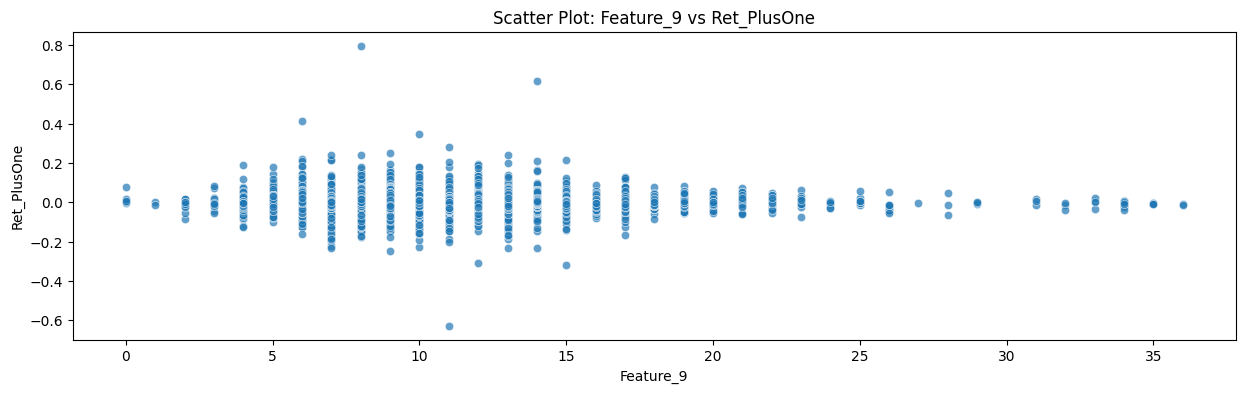

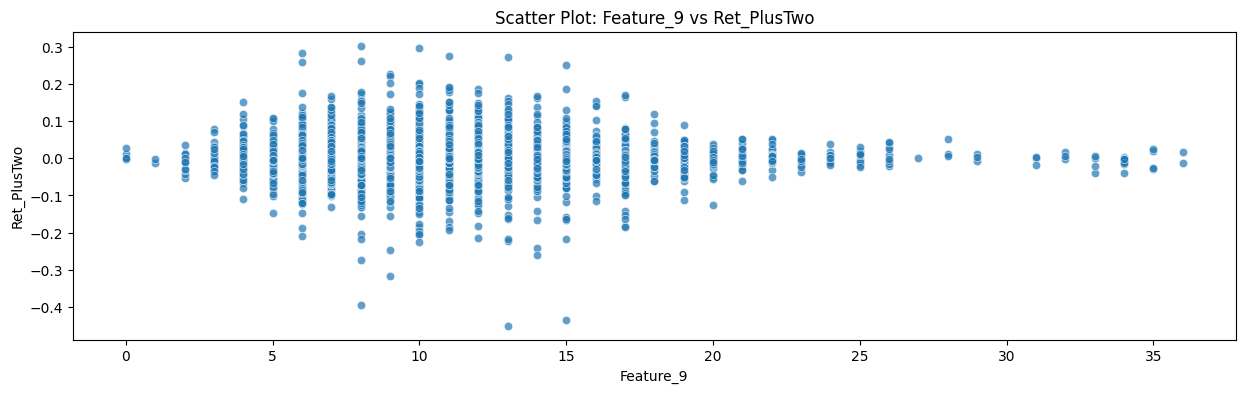

In [39]:
for feature in inter_top_features_1:
  for target in inter_ret_target_cols:
    plt.figure(figsize=(15, 4))
    sns.scatterplot(x=df[feature], y=df[target], alpha=0.7)
    plt.title(f'Scatter Plot: {feature} vs {target}')
    plt.xlabel(feature)
    plt.ylabel(target)
    plt.show()

In [41]:
inter_ret_cols

['Ret_MinusTwo', 'Ret_MinusOne', 'Ret_PlusOne', 'Ret_PlusTwo']

In [42]:
inter_correlations_2 = df[intra_ret_cols + inter_ret_target_cols].corr().drop(inter_ret_target_cols)
inter_top_features_2 = inter_correlations_2.abs().sort_values(by=inter_ret_target_cols, ascending=False).index[:10]

**Top 10 Correlating Intraday Return Distribution**

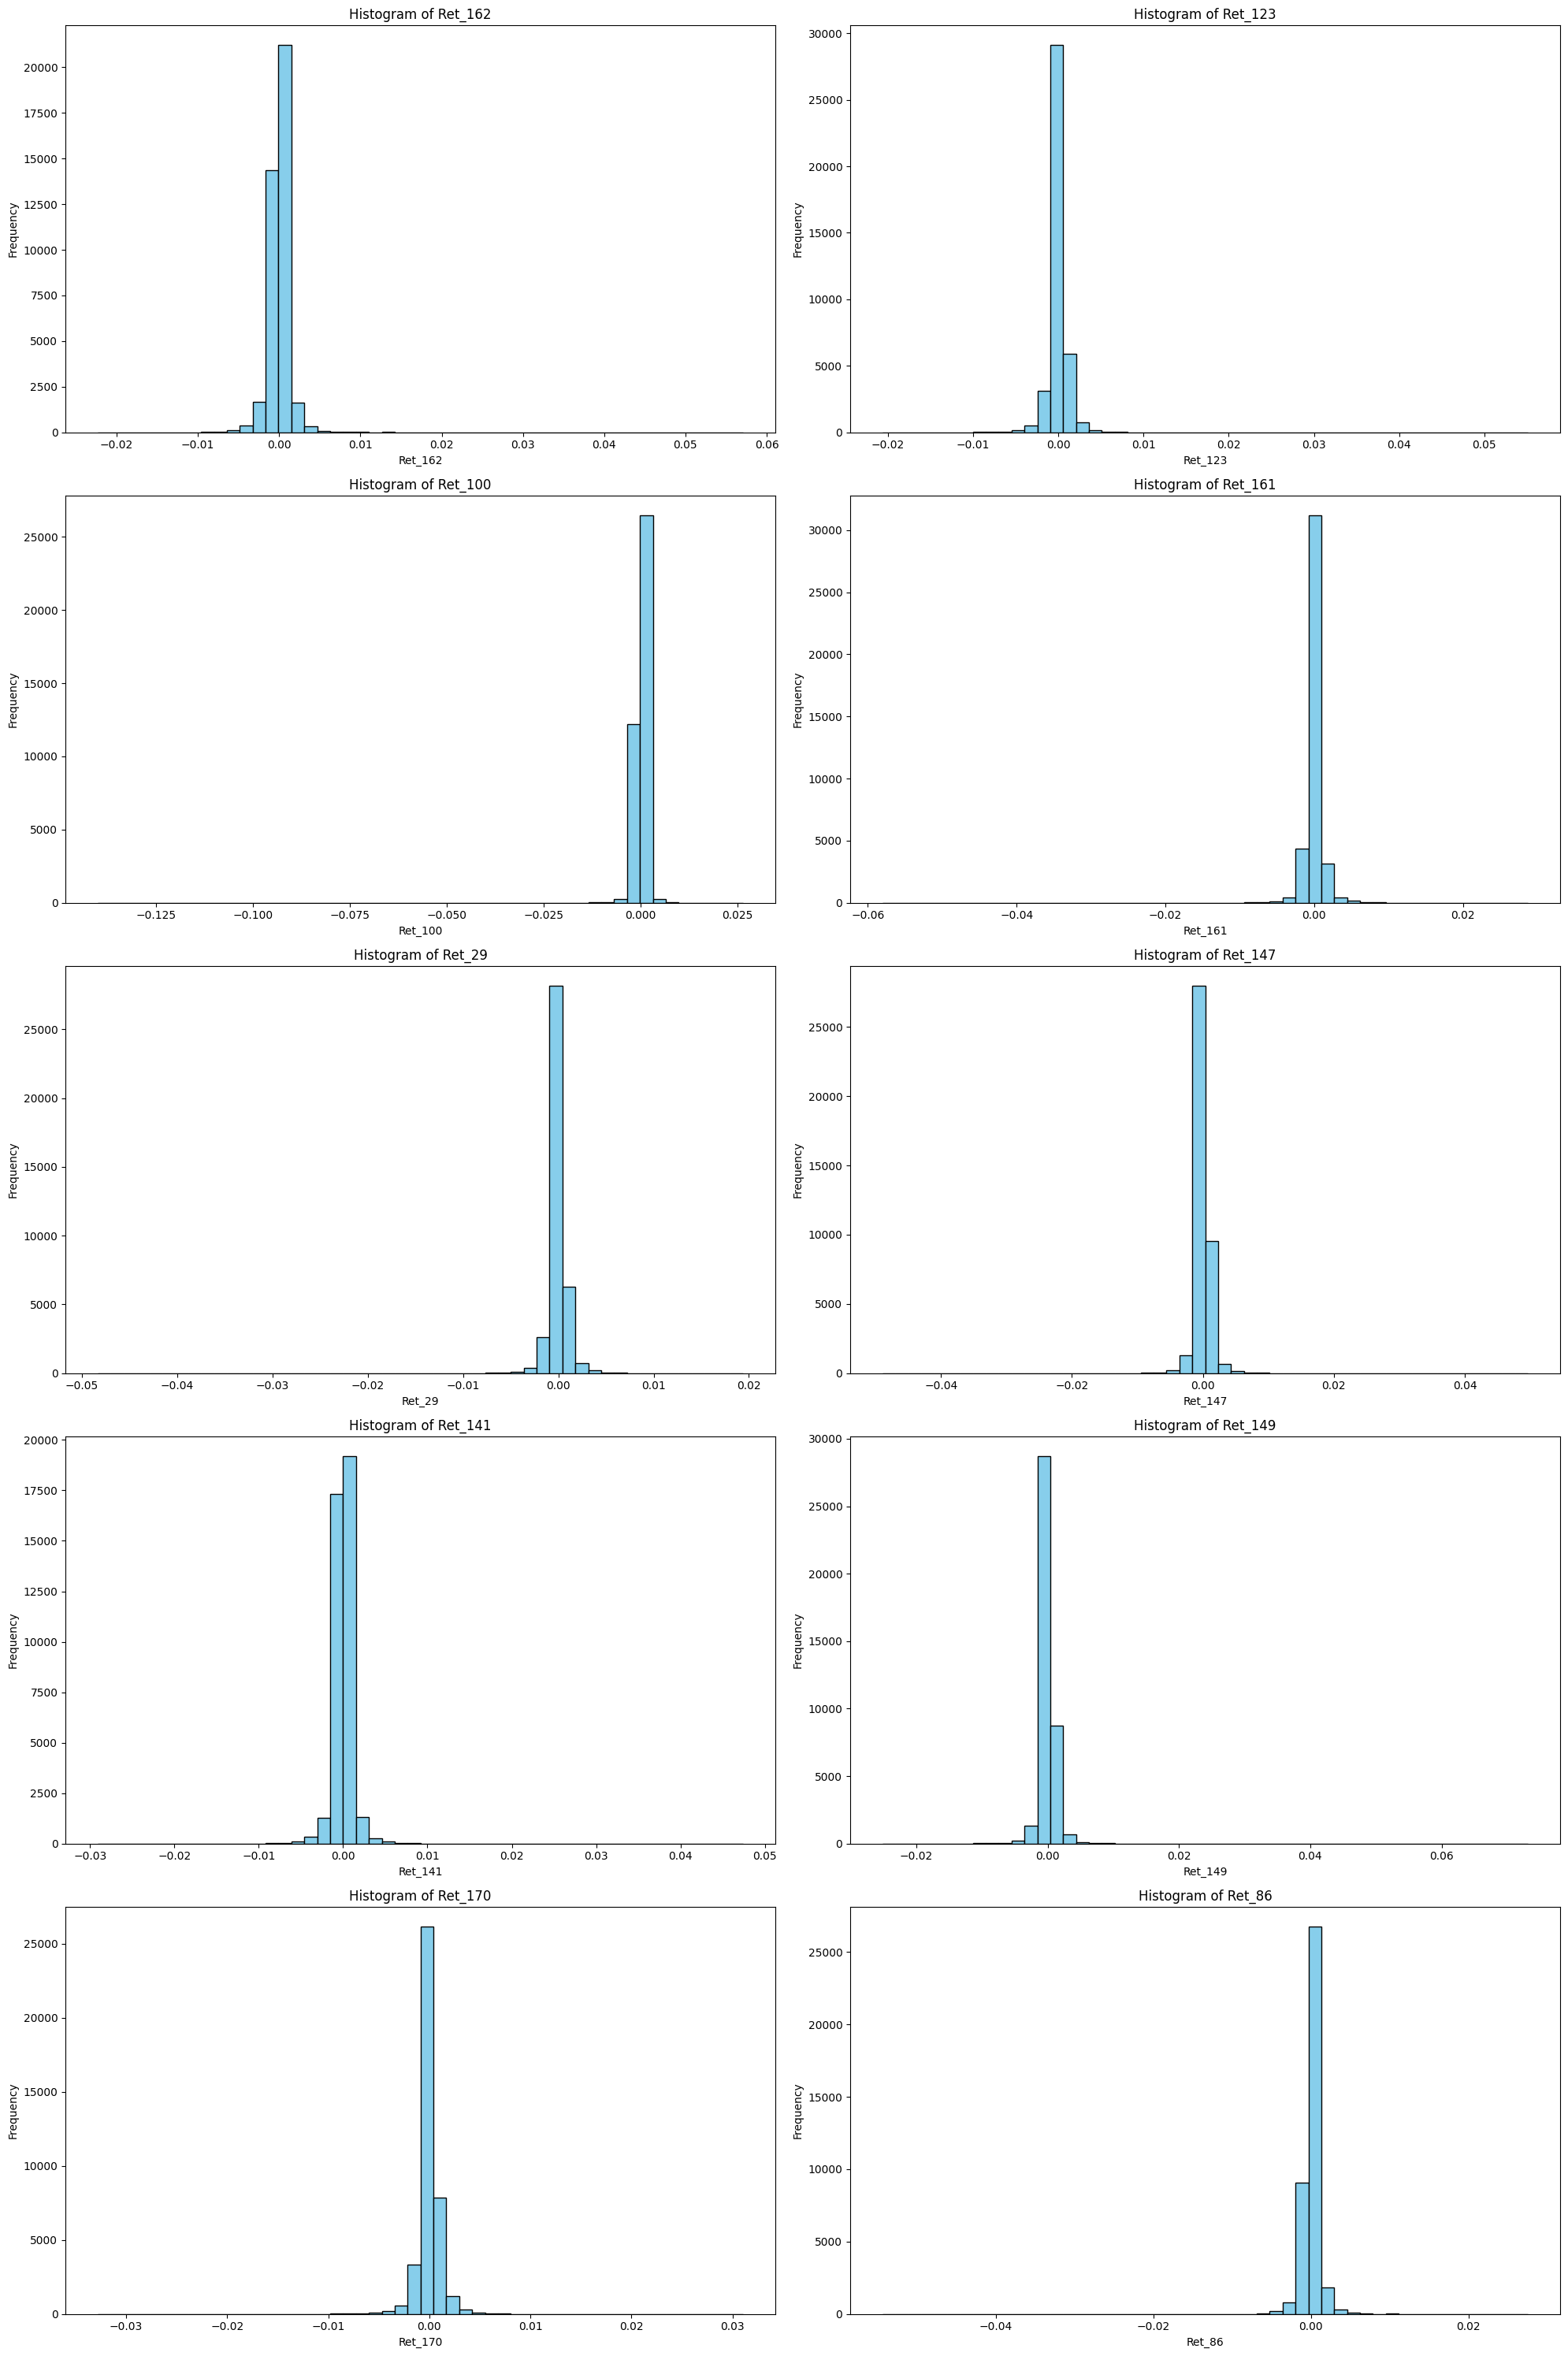

In [44]:
n_cols = 2
n_rows = 5

fig = plt.figure(figsize=(20, 30))
gs = GridSpec(n_rows, n_cols)

for idx, feature in enumerate(inter_top_features_2):
  ax = fig.add_subplot(gs[idx])
  ax.hist(df[feature].dropna(), bins=50, color='skyblue', edgecolor='black')
  ax.set_title(f'Histogram of {feature}')
  ax.set_xlabel(feature)
  ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [45]:
inter_top_features_2

Index(['Ret_162', 'Ret_123', 'Ret_100', 'Ret_161', 'Ret_29', 'Ret_147',
       'Ret_141', 'Ret_149', 'Ret_170', 'Ret_86'],
      dtype='object')

**Investigating Return Patterns**

In [49]:
nrows = df.shape[0]
nrows

40000

In [50]:
def plot_line_hist(df: pd.DataFrame, hist_xlim: tuple = None):
  nrows = df.shape[0]
  fig, axes = plt.subplots(nrows, 2, figsize=(15, 3*nrows))
  for i, idx in enumerate(df.index):
    line_ax = axes[i, 0]
    hist_ax = axes[i, 1]
    sns.lineplot(df.loc[idx], ax=line_ax, color='skyblue')
    sns.histplot(df.loc[idx], ax=hist_ax, color='skyblue', bins=50, edgecolor='black')
    if hist_xlim:
      hist_ax.set_xlim(hist_xlim)
    line_ax.set_title(f'Line Plot of {idx}')
    hist_ax.set_title(f'Histogram of {idx}')
    line_ax.set_xticks([])
    hist_ax.set_xlabel('')

In [51]:
intra_ret_samples = df[intra_ret_cols].sample(10)
intra_ret_samples

Ret_2     Ret_3         Ret_4     Ret_5     Ret_6     Ret_7  \
27427 -0.000722 -0.000002 -6.118602e-06  0.000651 -0.000640  0.000669   
36126 -0.000461  0.004639 -1.339327e-03  0.000886 -0.001392  0.000926   
9781   0.000400  0.000412 -4.148421e-04 -0.000426 -0.002087  0.000016   
35522 -0.000962  0.000106  8.786020e-04 -0.000272 -0.000688 -0.000185   
24095  0.000323 -0.000476  4.774313e-04 -0.000309  0.000162 -0.000022   
12594 -0.000212 -0.000655  9.885074e-05  0.000098 -0.000174 -0.000050   
11239  0.000312 -0.000319  2.916425e-04  0.000124  0.000000 -0.000925   
7558   0.000058  0.000529 -2.798674e-04 -0.000391  0.000145  0.000258   
39174  0.000659       NaN  5.085747e-07       NaN -0.001126 -0.001114   
39678 -0.000202       NaN -4.177847e-04  0.000210 -0.000818  0.000008   

          Ret_8     Ret_9        Ret_10    Ret_11  ...       Ret_171  \
27427 -0.000519  0.000590 -9.712641e-07 -0.000017  ...  7.079623e-04   
36126 -0.001396  0.001405  1.924934e-06 -0.000003  ... -2.864323e-03   
9781   0.000418  0.002070  8.516048e-05 -0.000100  ...  4.228574e-04   
35522 -0.000388  0.000100  8.524357e-05 -0.000640  ...  4.930132e-04   
24095  0.000183 -0.000456 -1.534650e-04  0.000173  ...  6.278035e-04   
12594 -0.000439  0.000209  4.220684e-04 -0.000175  ... -2.191180e-05   
11239 -0.000241  0.000459 -3.071531e-04 -0.000305  ... -2.746570e-04   
7558   0.000004 -0.000241  2.601637e-04 -0.000536  ...  1.181751e-08   
39174  0.000005       NaN           NaN       NaN  ... -2.048241e-03   
39678  0.000030  0.001013           NaN -0.000003  ... -4.064929e-04   

            Ret_172       Ret_173   Ret_174   Ret_175   Ret_176   Ret_177  \
27427 -1.448571e-03  2.102699e-05  0.000360  0.000361  0.000028  0.000007   
36126 -2.734138e-07  1.917424e-03  0.001446  0.000009 -0.000002  0.000468   
9781  -4.197307e-04  4.250241e-04  0.000015  0.001268 -0.000416  0.000420   
35522 -7.724507e-04  1.835168e-04  0.000587  0.000299 -0.000009 -0.000213   
24095 -1.618286e-04  4.723759e-04 -0.000001 -0.000302 -0.001278 -0.000152   
12594 -2.222949e-04  2.314477e-04  0.000199 -0.000656 -0.000451  0.000428   
11239  6.334471e-04 -4.376602e-05  0.000046  0.000802  0.000420  0.000302   
7558   2.738940e-04  3.156706e-06 -0.000130  0.000635  0.000005  0.001295   
39174 -4.522116e-03  1.827919e-07  0.000908 -0.000686  0.000899  0.000238   
39678  8.193771e-04  1.433213e-03 -0.000619  0.000214  0.000222  0.000829   

        Ret_178   Ret_179       Ret_180  
27427 -0.001366  0.001305  9.879772e-07  
36126  0.000961  0.000962  9.774696e-04  
9781  -0.001265  0.000413 -8.378398e-04  
35522 -0.000366 -0.000190  1.036790e-04  
24095 -0.000627 -0.000942 -4.786199e-04  
12594 -0.000216 -0.000227 -6.450717e-04  
11239  0.000291  0.000516  4.042694e-04  
7558   0.000810  0.000809  2.506649e-04  
39174  0.001808 -0.002954  4.529381e-04  
39678 -0.000401 -0.000431 -8.334961e-04  

[10 rows x 179 columns]

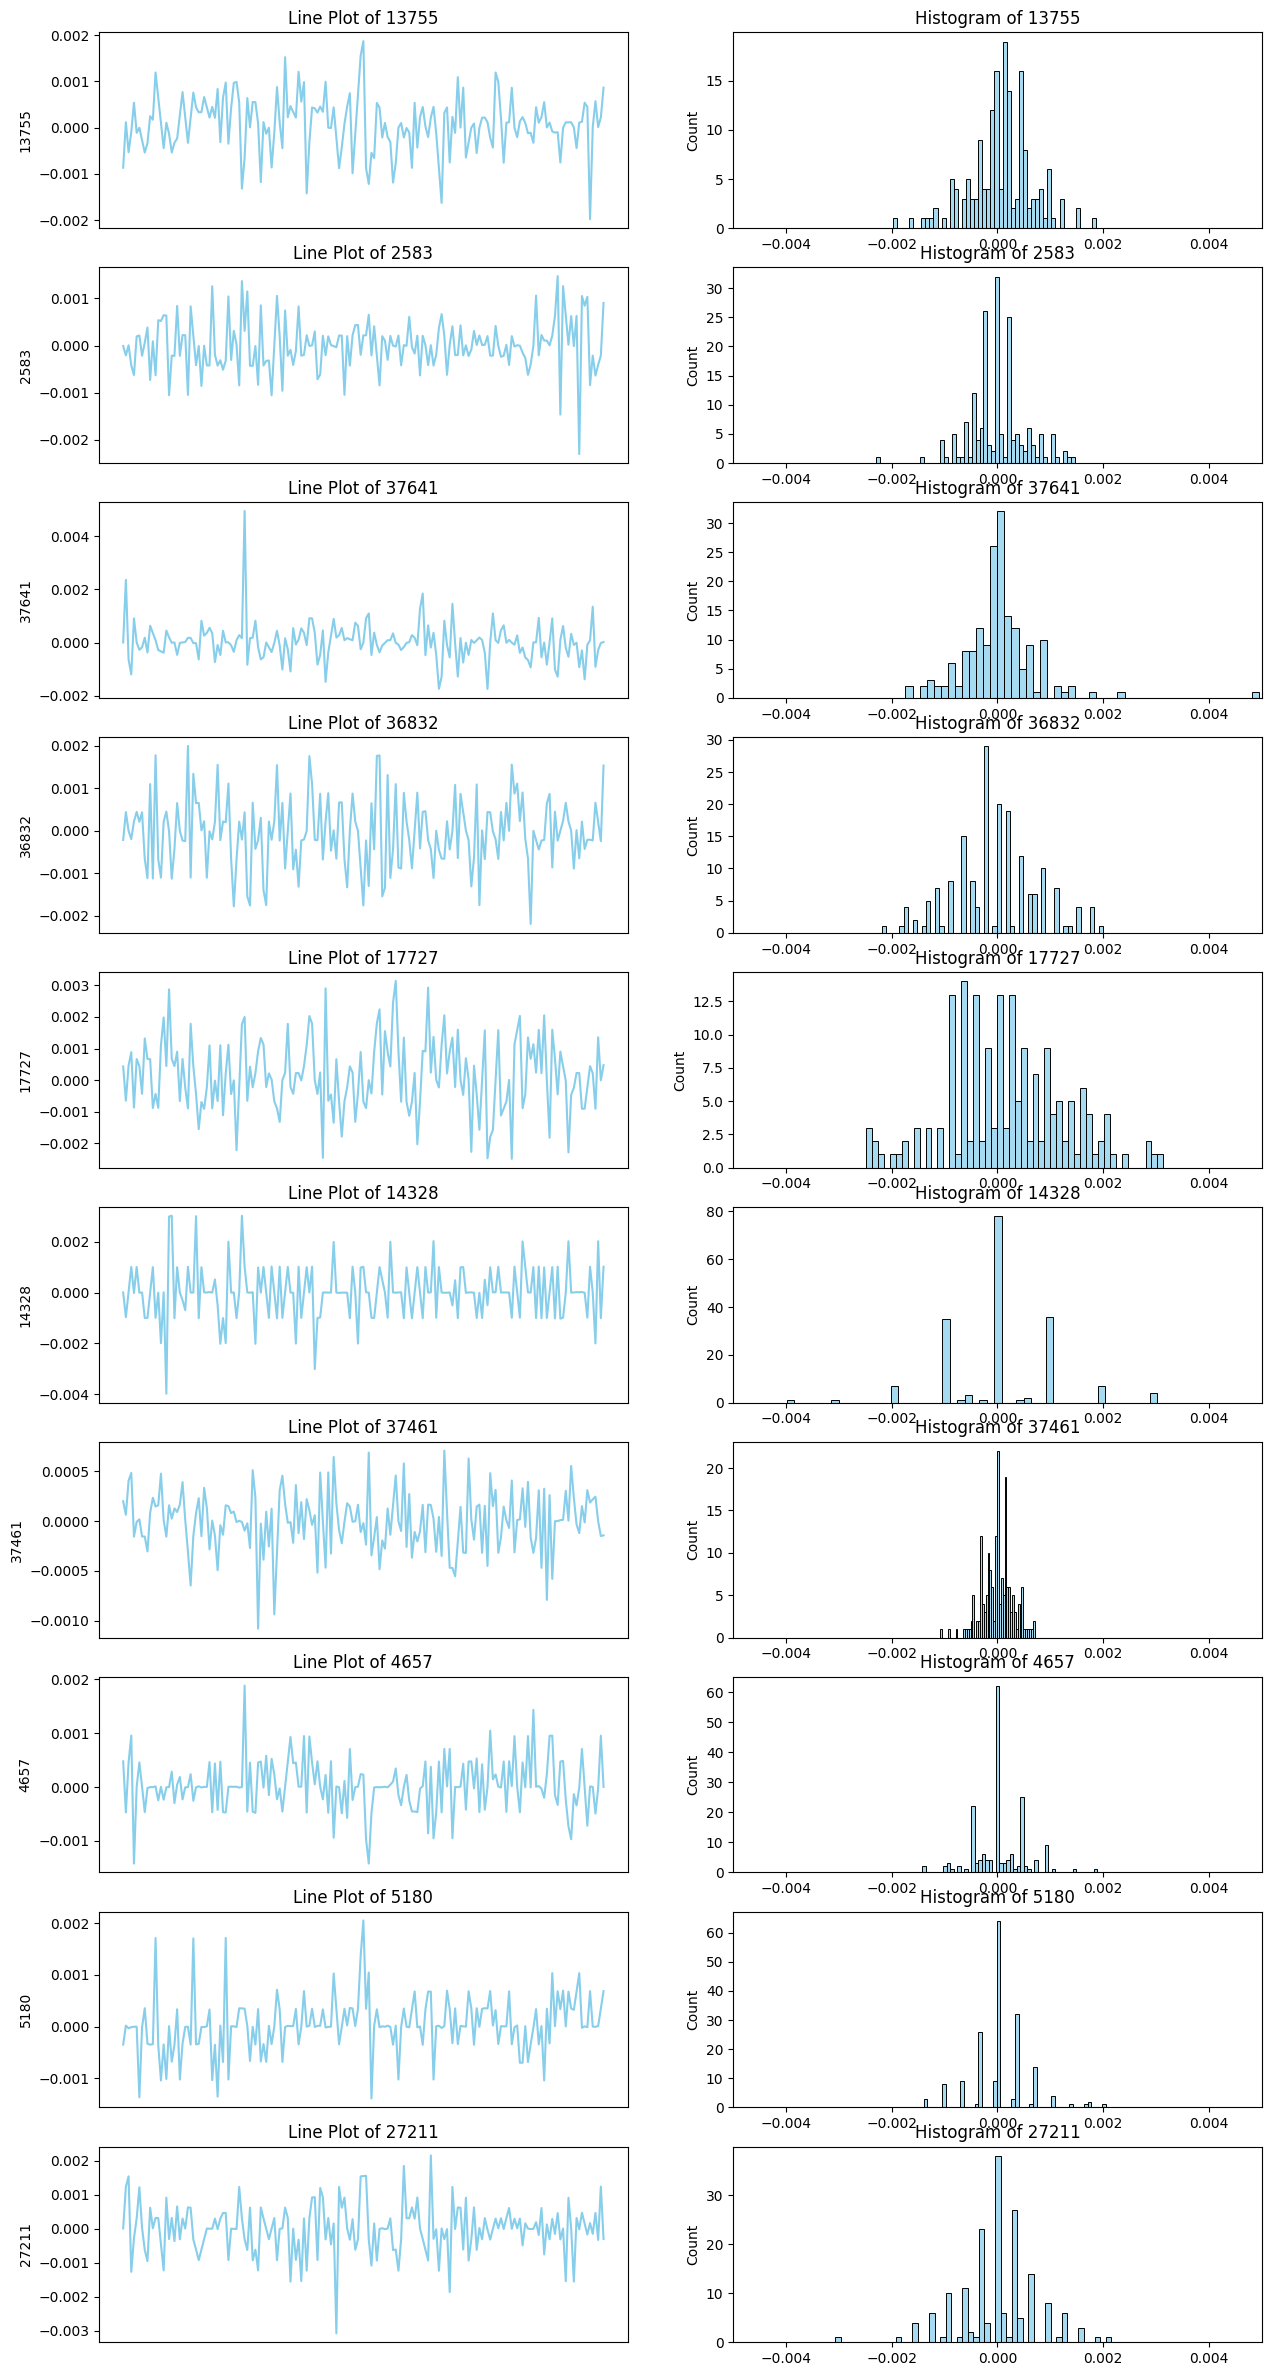

In [52]:
#Evaluating with intraday return samples
intra_ret_samples = df[intra_ret_cols].sample(10)
plot_line_hist(intra_ret_samples, hist_xlim=(-0.005, 0.005))

(-0.0005, 0.0005)

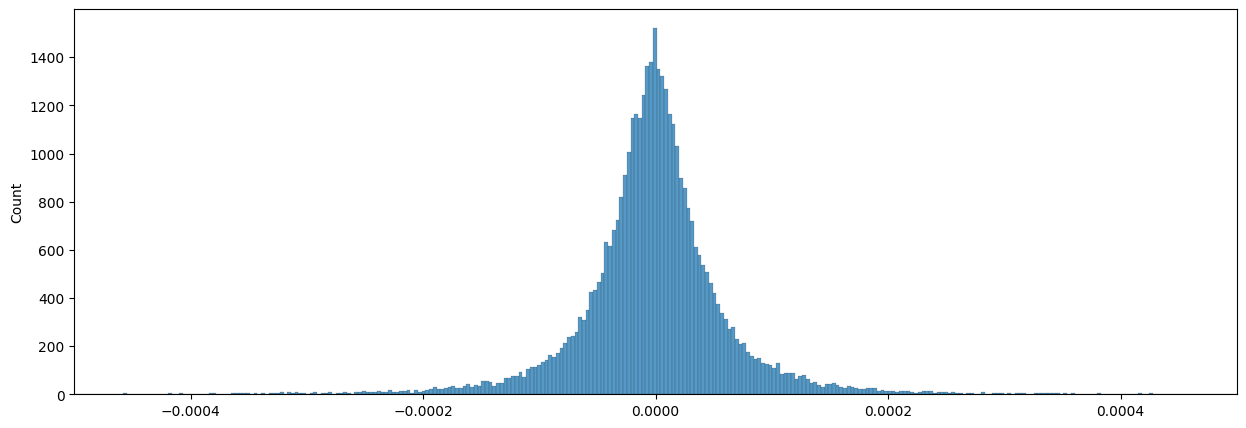

In [53]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.histplot(df.loc[:, intra_ret_cols].mean(axis=1))
ax.set_xlim(-0.0005, 0.0005)

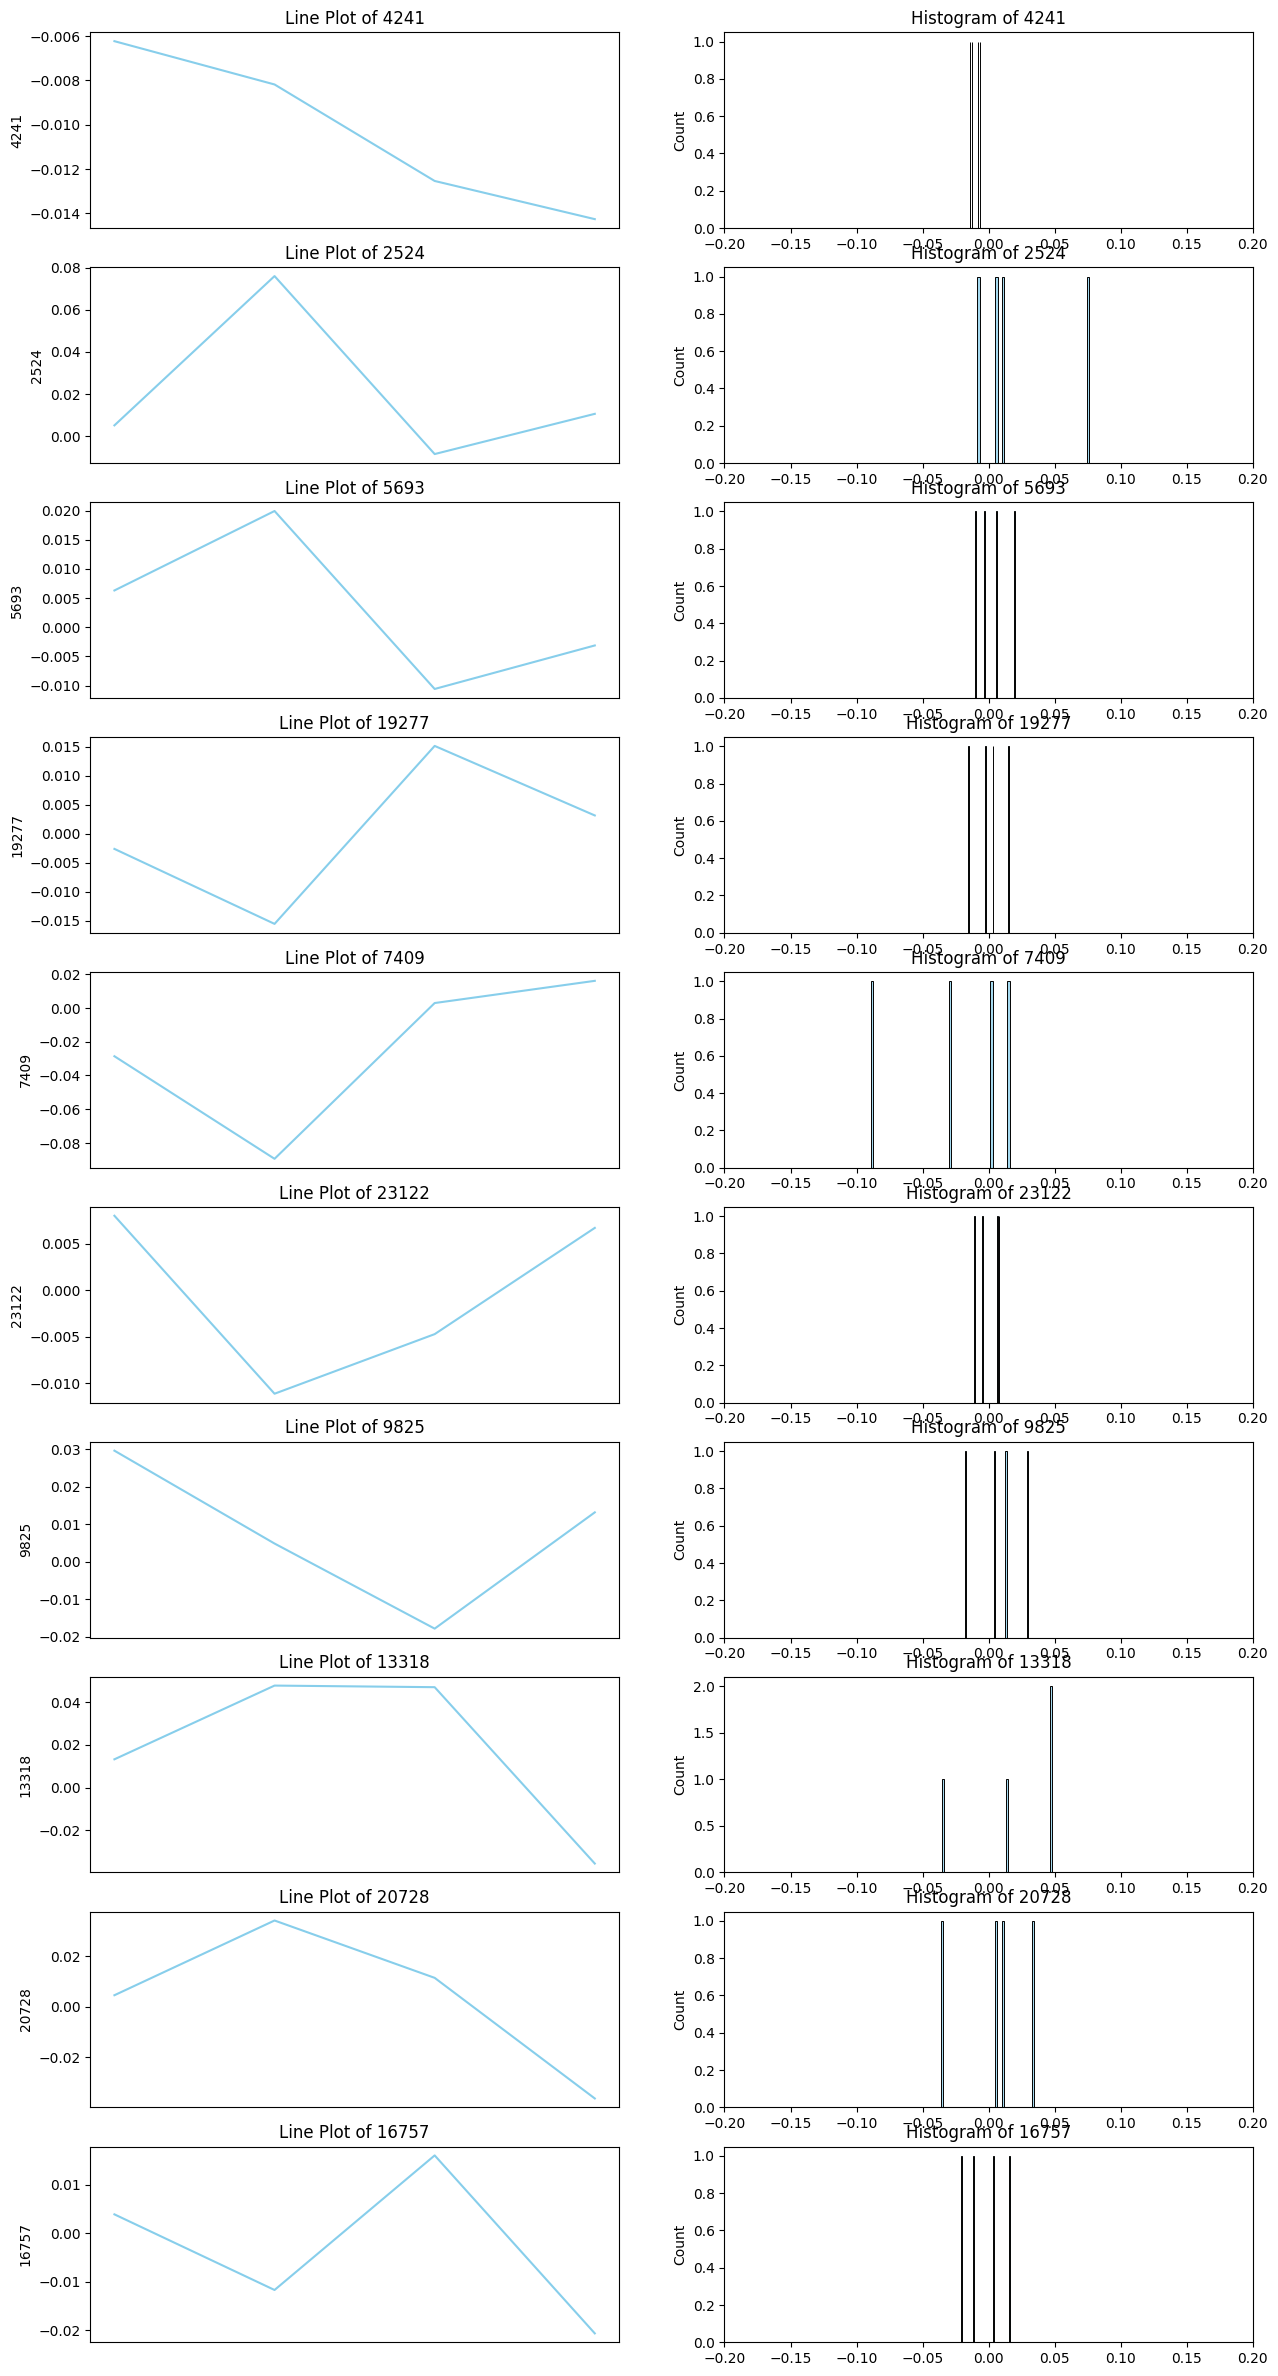

In [54]:
#Evaluating with interday return samples
inter_ret_samples = df[inter_ret_cols].sample(10)
plot_line_hist(inter_ret_samples, hist_xlim=(-0.2, 0.2))

**Average Return on the Dataset**

(-0.1, 0.1)

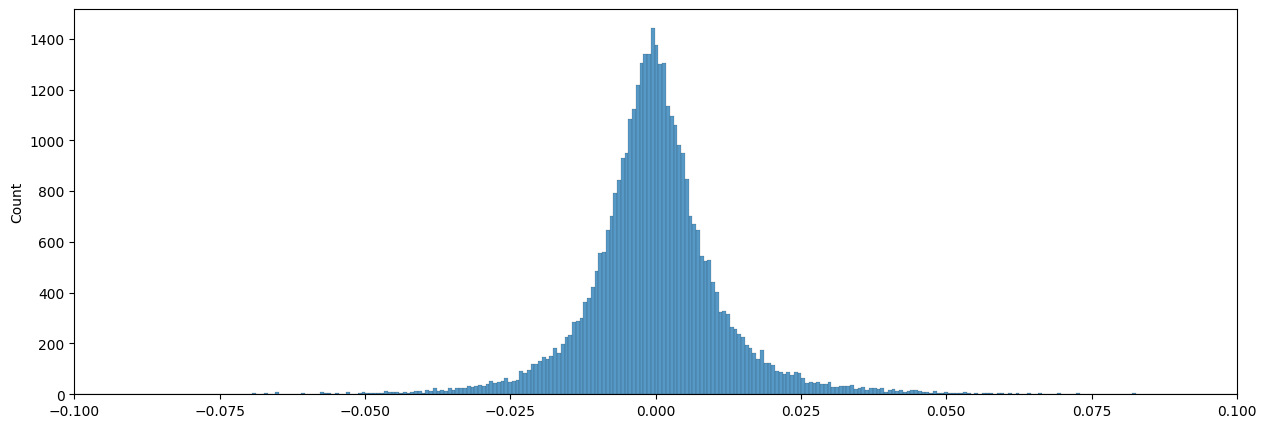

In [57]:
fig,ax = plt.subplots(figsize=(15,5))
ax = sns.histplot(df.loc[:, inter_ret_cols].mean(axis=1))
ax.set_xlim(-0.1, 0.1)

**Stock Returns Trend**

In [61]:
trend_data = df.loc[:,intra_ret_feat_cols].dropna().values

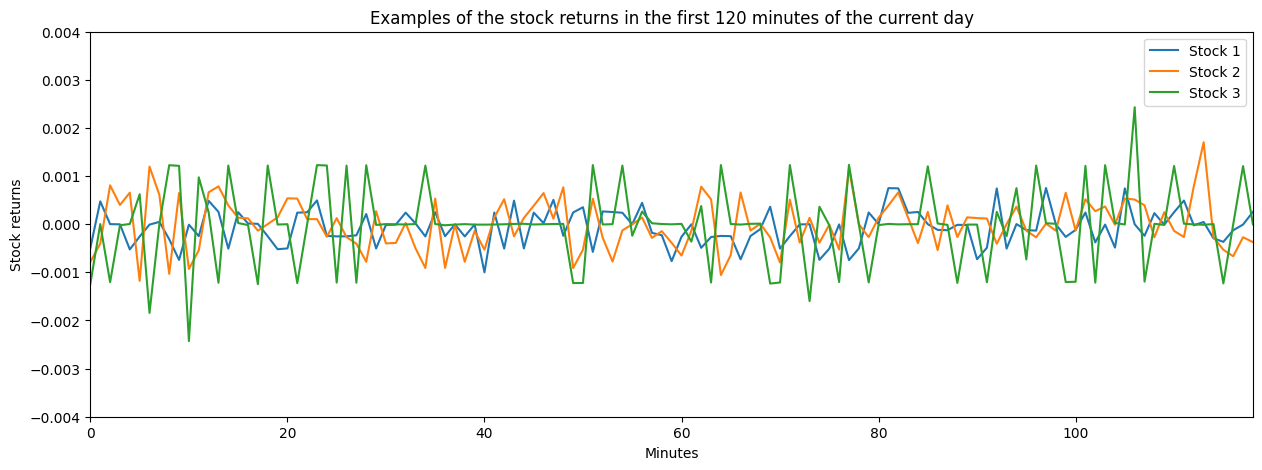

In [65]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(trend_data[0, :], label = 'Stock 1')
plt.plot(trend_data[1, :], label = 'Stock 2')
plt.plot(trend_data[2, :], label = 'Stock 3')
plt.ylim([-0.004, 0.004])
plt.xlim([0, 118])
plt.ylabel('Stock returns')
plt.xlabel('Minutes')
plt.title('Examples of the stock returns in the first 120 minutes of the current day')
plt.legend()
plt.show()

**Statistical Justification**

In [67]:
df.loc[:,intra_ret_feat_cols].describe()

Ret_2         Ret_3         Ret_4         Ret_5         Ret_6  \
count  3.894600e+04  3.875500e+04  38798.000000  38725.000000  38680.000000   
mean   5.600930e-06 -7.659483e-06     -0.000006     -0.000006     -0.000019   
std    9.501528e-04  9.750796e-04      0.000994      0.000962      0.000924   
min   -1.311777e-02 -3.854170e-02     -0.040386     -0.030359     -0.024735   
25%   -3.215495e-04 -3.270489e-04     -0.000323     -0.000326     -0.000333   
50%   -1.989567e-07 -1.432130e-07      0.000000      0.000000      0.000000   
75%    3.122045e-04  3.170894e-04      0.000323      0.000323      0.000312   
max    3.214902e-02  2.177922e-02      0.028929      0.018692      0.040100   

              Ret_7         Ret_8         Ret_9        Ret_10        Ret_11  \
count  38772.000000  3.879000e+04  3.868300e+04  38687.000000  38631.000000   
mean       0.000030  2.752578e-05  4.696042e-07      0.000004     -0.000004   
std        0.001007  9.215315e-04  9.517938e-04      0.000989      0.000981   
min       -0.056589 -1.975299e-02 -2.955805e-02     -0.030077     -0.015547   
25%       -0.000292 -3.043271e-04 -3.061895e-04     -0.000316     -0.000314   
50%        0.000001  2.377959e-07  0.000000e+00      0.000000      0.000000   
75%        0.000339  3.352720e-04  3.255944e-04      0.000317      0.000312   
max        0.029290  1.854491e-02  2.146587e-02      0.028523      0.030518   

       ...       Ret_111       Ret_112       Ret_113       Ret_114  \
count  ...  39360.000000  3.953800e+04  3.945300e+04  39460.000000   
mean   ...      0.000019 -1.097507e-05  1.989394e-05     -0.000014   
std    ...      0.001042  1.069841e-03  1.214760e-03      0.001008   
min    ...     -0.027735 -2.577588e-02 -9.052323e-02     -0.031687   
25%    ...     -0.000331 -3.514277e-04 -3.312341e-04     -0.000360   
50%    ...      0.000001 -2.663356e-07  6.910963e-07     -0.000001   
75%    ...      0.000362  3.476702e-04  3.666458e-04      0.000323   
max    ...      0.021391  4.499840e-02  2.610010e-02      0.018792   

            Ret_115       Ret_116       Ret_117       Ret_118       Ret_119  \
count  39391.000000  3.939900e+04  3.952800e+04  39488.000000  3.949100e+04   
mean       0.000049  2.916865e-05  3.600343e-07     -0.000032  1.348472e-05   
std        0.000998  1.071573e-03  1.128114e-03      0.001082  1.125495e-03   
min       -0.014537 -3.515707e-02 -2.943088e-02     -0.066786 -7.788409e-02   
25%       -0.000305 -3.307106e-04 -3.444464e-04     -0.000357 -3.354549e-04   
50%        0.000002  6.571182e-07  0.000000e+00     -0.000001  7.672148e-07   
75%        0.000357  3.562683e-04  3.483433e-04      0.000320  3.618646e-04   
max        0.021729  2.965287e-02  4.734717e-02      0.022986  2.552057e-02   

            Ret_120  
count  4.000000e+04  
mean  -2.081735e-06  
std    1.207381e-03  
min   -2.844145e-02  
25%   -3.465326e-04  
50%   -8.172886e-08  
75%    3.437908e-04  
max    1.160767e-01  

[8 rows x 119 columns]

In [68]:
df.loc[:,inter_ret_feat_cols].describe()

Ret_MinusTwo  Ret_MinusOne
count  40000.000000  40000.000000
mean       0.000784     -0.000803
std        0.028279      0.030569
min       -0.536283     -0.514720
25%       -0.010687     -0.010830
50%        0.000112     -0.000665
75%        0.010987      0.008976
max        0.894024      0.852139

Intraday Return Volatility Analysis

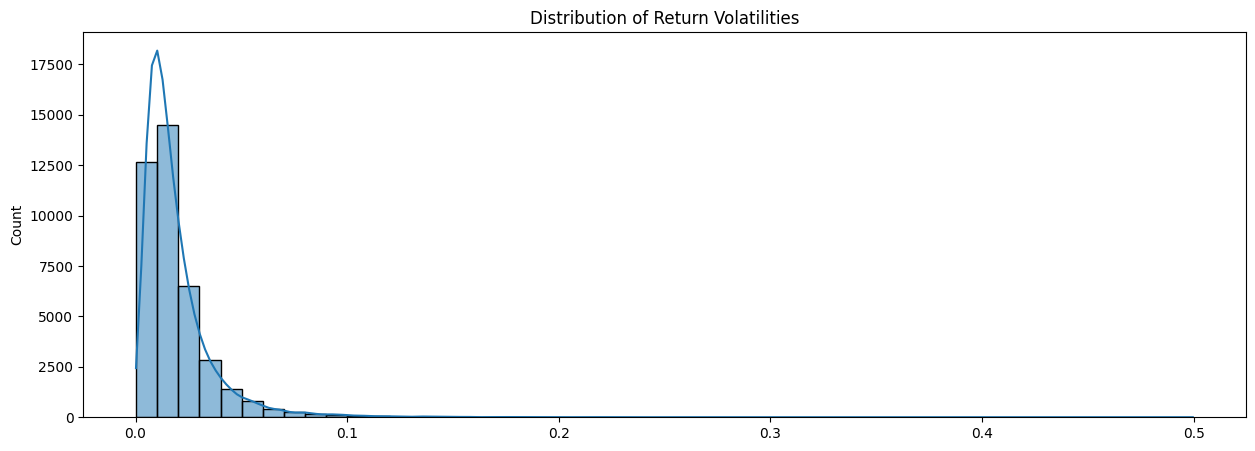

In [70]:
volatilities = df.loc[:,inter_ret_cols].std(axis=1)  # Volatility across interday returns

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(volatilities, kde=True, bins=50)
plt.title('Distribution of Return Volatilities')
plt.show()

This volatility distribution shows a strongly rightly skewed distribution, indicating that the market is relatively stable with most of the volatility close to zero - potentially due to data sourcing being on less trading periods.

The extensive tail reveals outliers of high volatility - potentially due to market news, market shocks or intense speculations, etc

Text(0.5, 0, 'Log_Volatility')

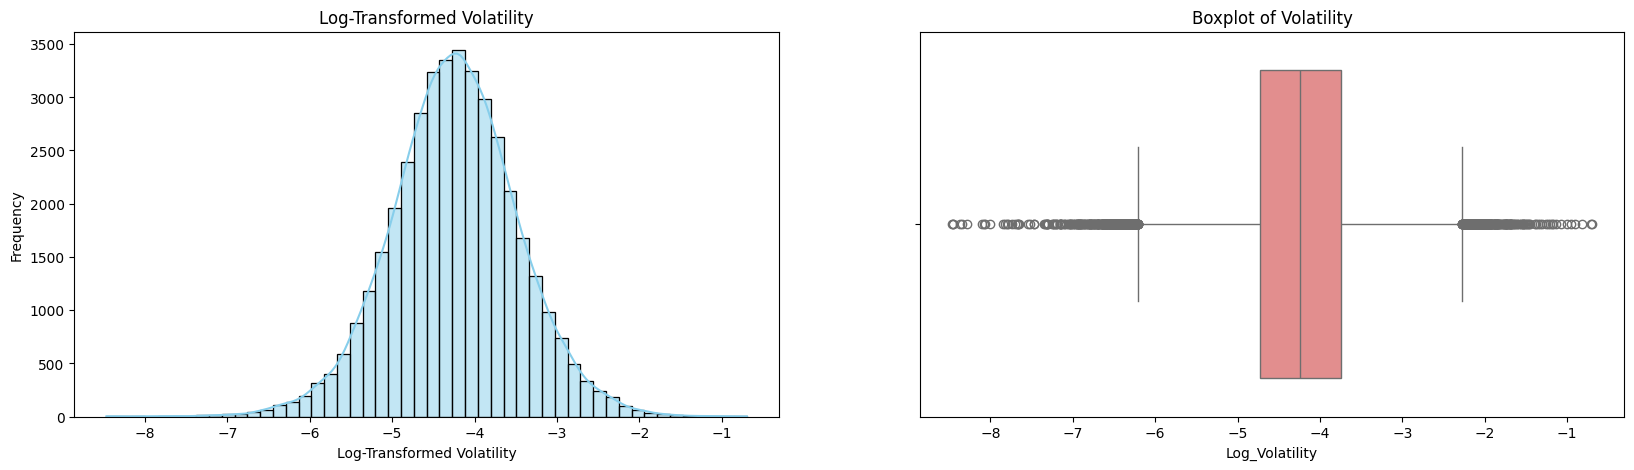

In [73]:
df_copy = df.copy()
df_copy['log_volatility'] = np.log(volatilities +1e-8)

fig, ax = plt.subplots(1,2, figsize=(20, 5))
sns.histplot(df_copy['log_volatility'], kde=True, bins=50, ax=ax[0], color='skyblue')
ax[0].set_title('Log-Transformed Volatility')
ax[0].set_xlabel('Log-Transformed Volatility')
ax[0].set_ylabel('Frequency')

sns.boxplot(x=df_copy['log_volatility'], ax=ax[1], color='lightcoral')
ax[1].set_title('Boxplot of Volatility')
ax[1].set_xlabel('Log_Volatility')

In [74]:
#Creating a volatility feature in model data after transformation of initial volatility
df['log_volatility'] = df_copy['log_volatility']

Interday Return Distribution Analysis

In [77]:
# Understanding skewness and kurtosis of interday returns

print(df[['Ret_PlusOne', 'Ret_PlusTwo']].skew(),'\n')
print(df[['Ret_PlusOne', 'Ret_PlusTwo']].kurtosis())

Ret_PlusOne    0.941967
Ret_PlusTwo   -0.213174
dtype: float64 

Ret_PlusOne    57.536356
Ret_PlusTwo    21.882270
dtype: float64


For the Ret_PlusOne return the significantly positive skewedness suggest a tendency for a higher-than-average returns for the stocks distribution and the >3 kurtosis values indicates a highly leptokurtic distribution indicative of extreme outliers.

The Ret_PlusTwo return has a negatively skewed distribution, indicating the feature has small tendency to fall slightly below the average return and the high kurtosis value also indicates a highly leptokurtic distribution pointing to extreme outliers, but not as risky as Ret_PlusOne

Exploring Intraday and Interday Relationships

Text(0.5, 1.0, 'Cumulative Intraday Returns vs Ret_PlusTwo')

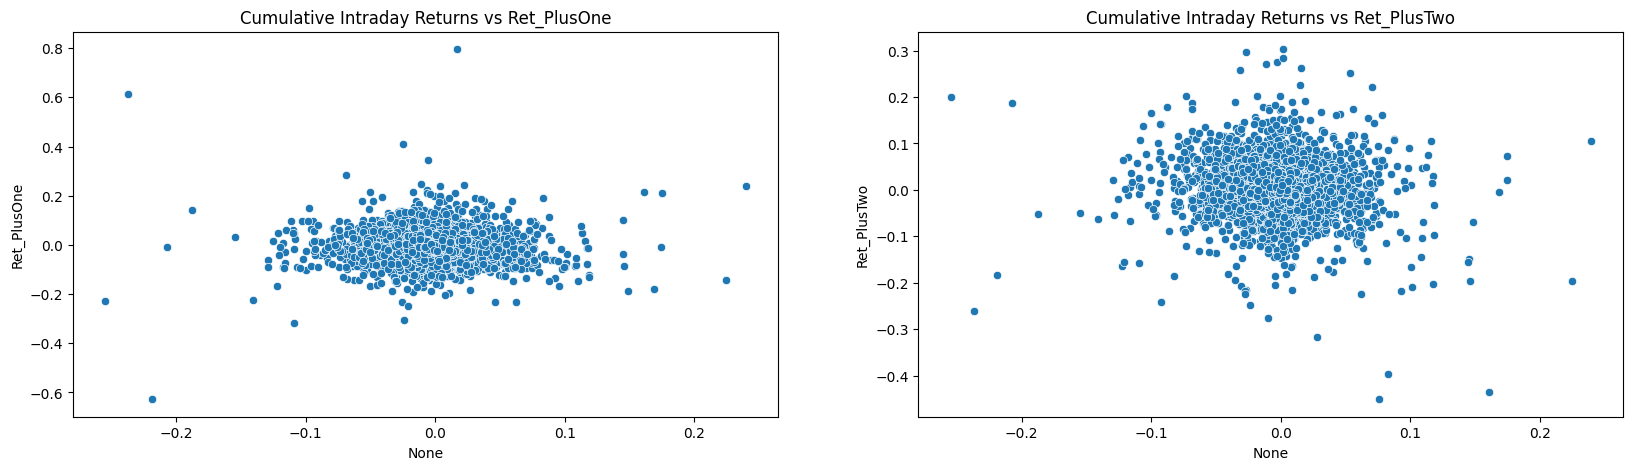

In [80]:
intraday_cumsum = df[intra_ret_cols].sum(axis=1)

fig,ax = plt.subplots(1,2, figsize=(20,5))
sns.scatterplot(x=intraday_cumsum, y=df['Ret_PlusOne'], ax=ax[0])
ax[0].set_title('Cumulative Intraday Returns vs Ret_PlusOne')

sns.scatterplot(x=intraday_cumsum, y=df['Ret_PlusTwo'], ax=ax[1])
ax[1].set_title('Cumulative Intraday Returns vs Ret_PlusTwo')

Timeseries Analysis

Text(0.5, 1.0, 'Autocorrelation Plot of Cumulative Intraday Returns')

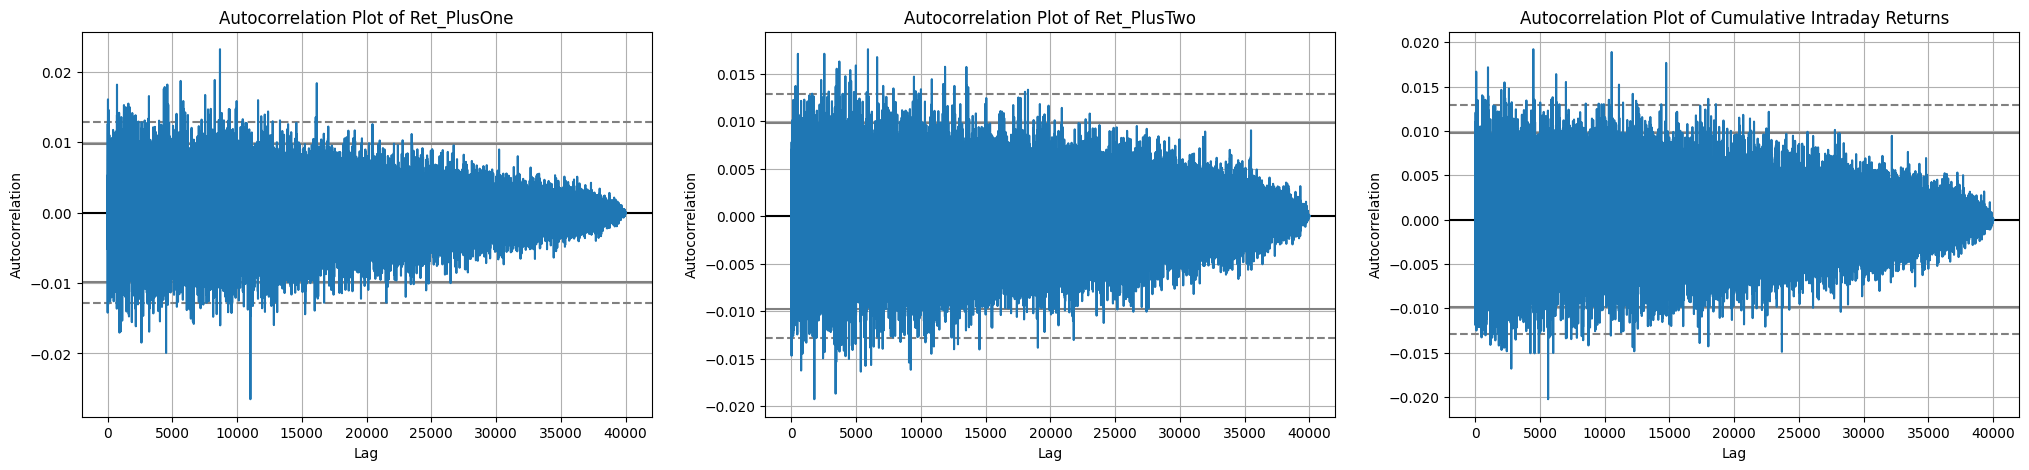

In [83]:
fig, ax = plt.subplots(1,3, figsize=(25,5))
autocorrelation_plot(df['Ret_PlusOne'].dropna(), ax=ax[0])
ax[0].set_title('Autocorrelation Plot of Ret_PlusOne')

autocorrelation_plot(df['Ret_PlusTwo'].dropna(), ax=ax[1])
ax[1].set_title('Autocorrelation Plot of Ret_PlusTwo')

autocorrelation_plot(intraday_cumsum, ax=ax[2])
ax[2].set_title('Autocorrelation Plot of Cumulative Intraday Returns')

**Preprocessing**

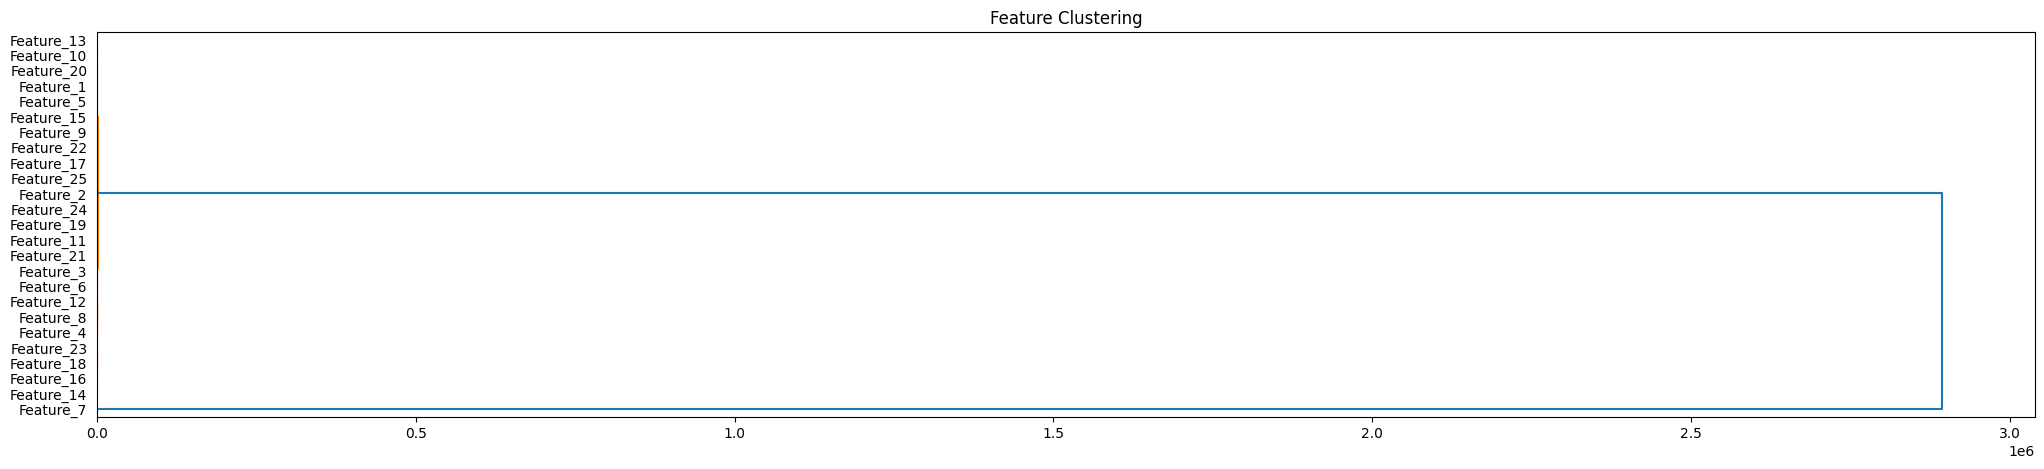

In [85]:
#Feature selection
from scipy.cluster.hierarchy import dendrogram, linkage

fig, ax = plt.subplots(figsize=(25,5))
Z = linkage(df[feature_cols].dropna().T, 'ward')
dendrogram(Z, labels=feature_cols, orientation='right')
plt.title('Feature Clustering')
plt.show()

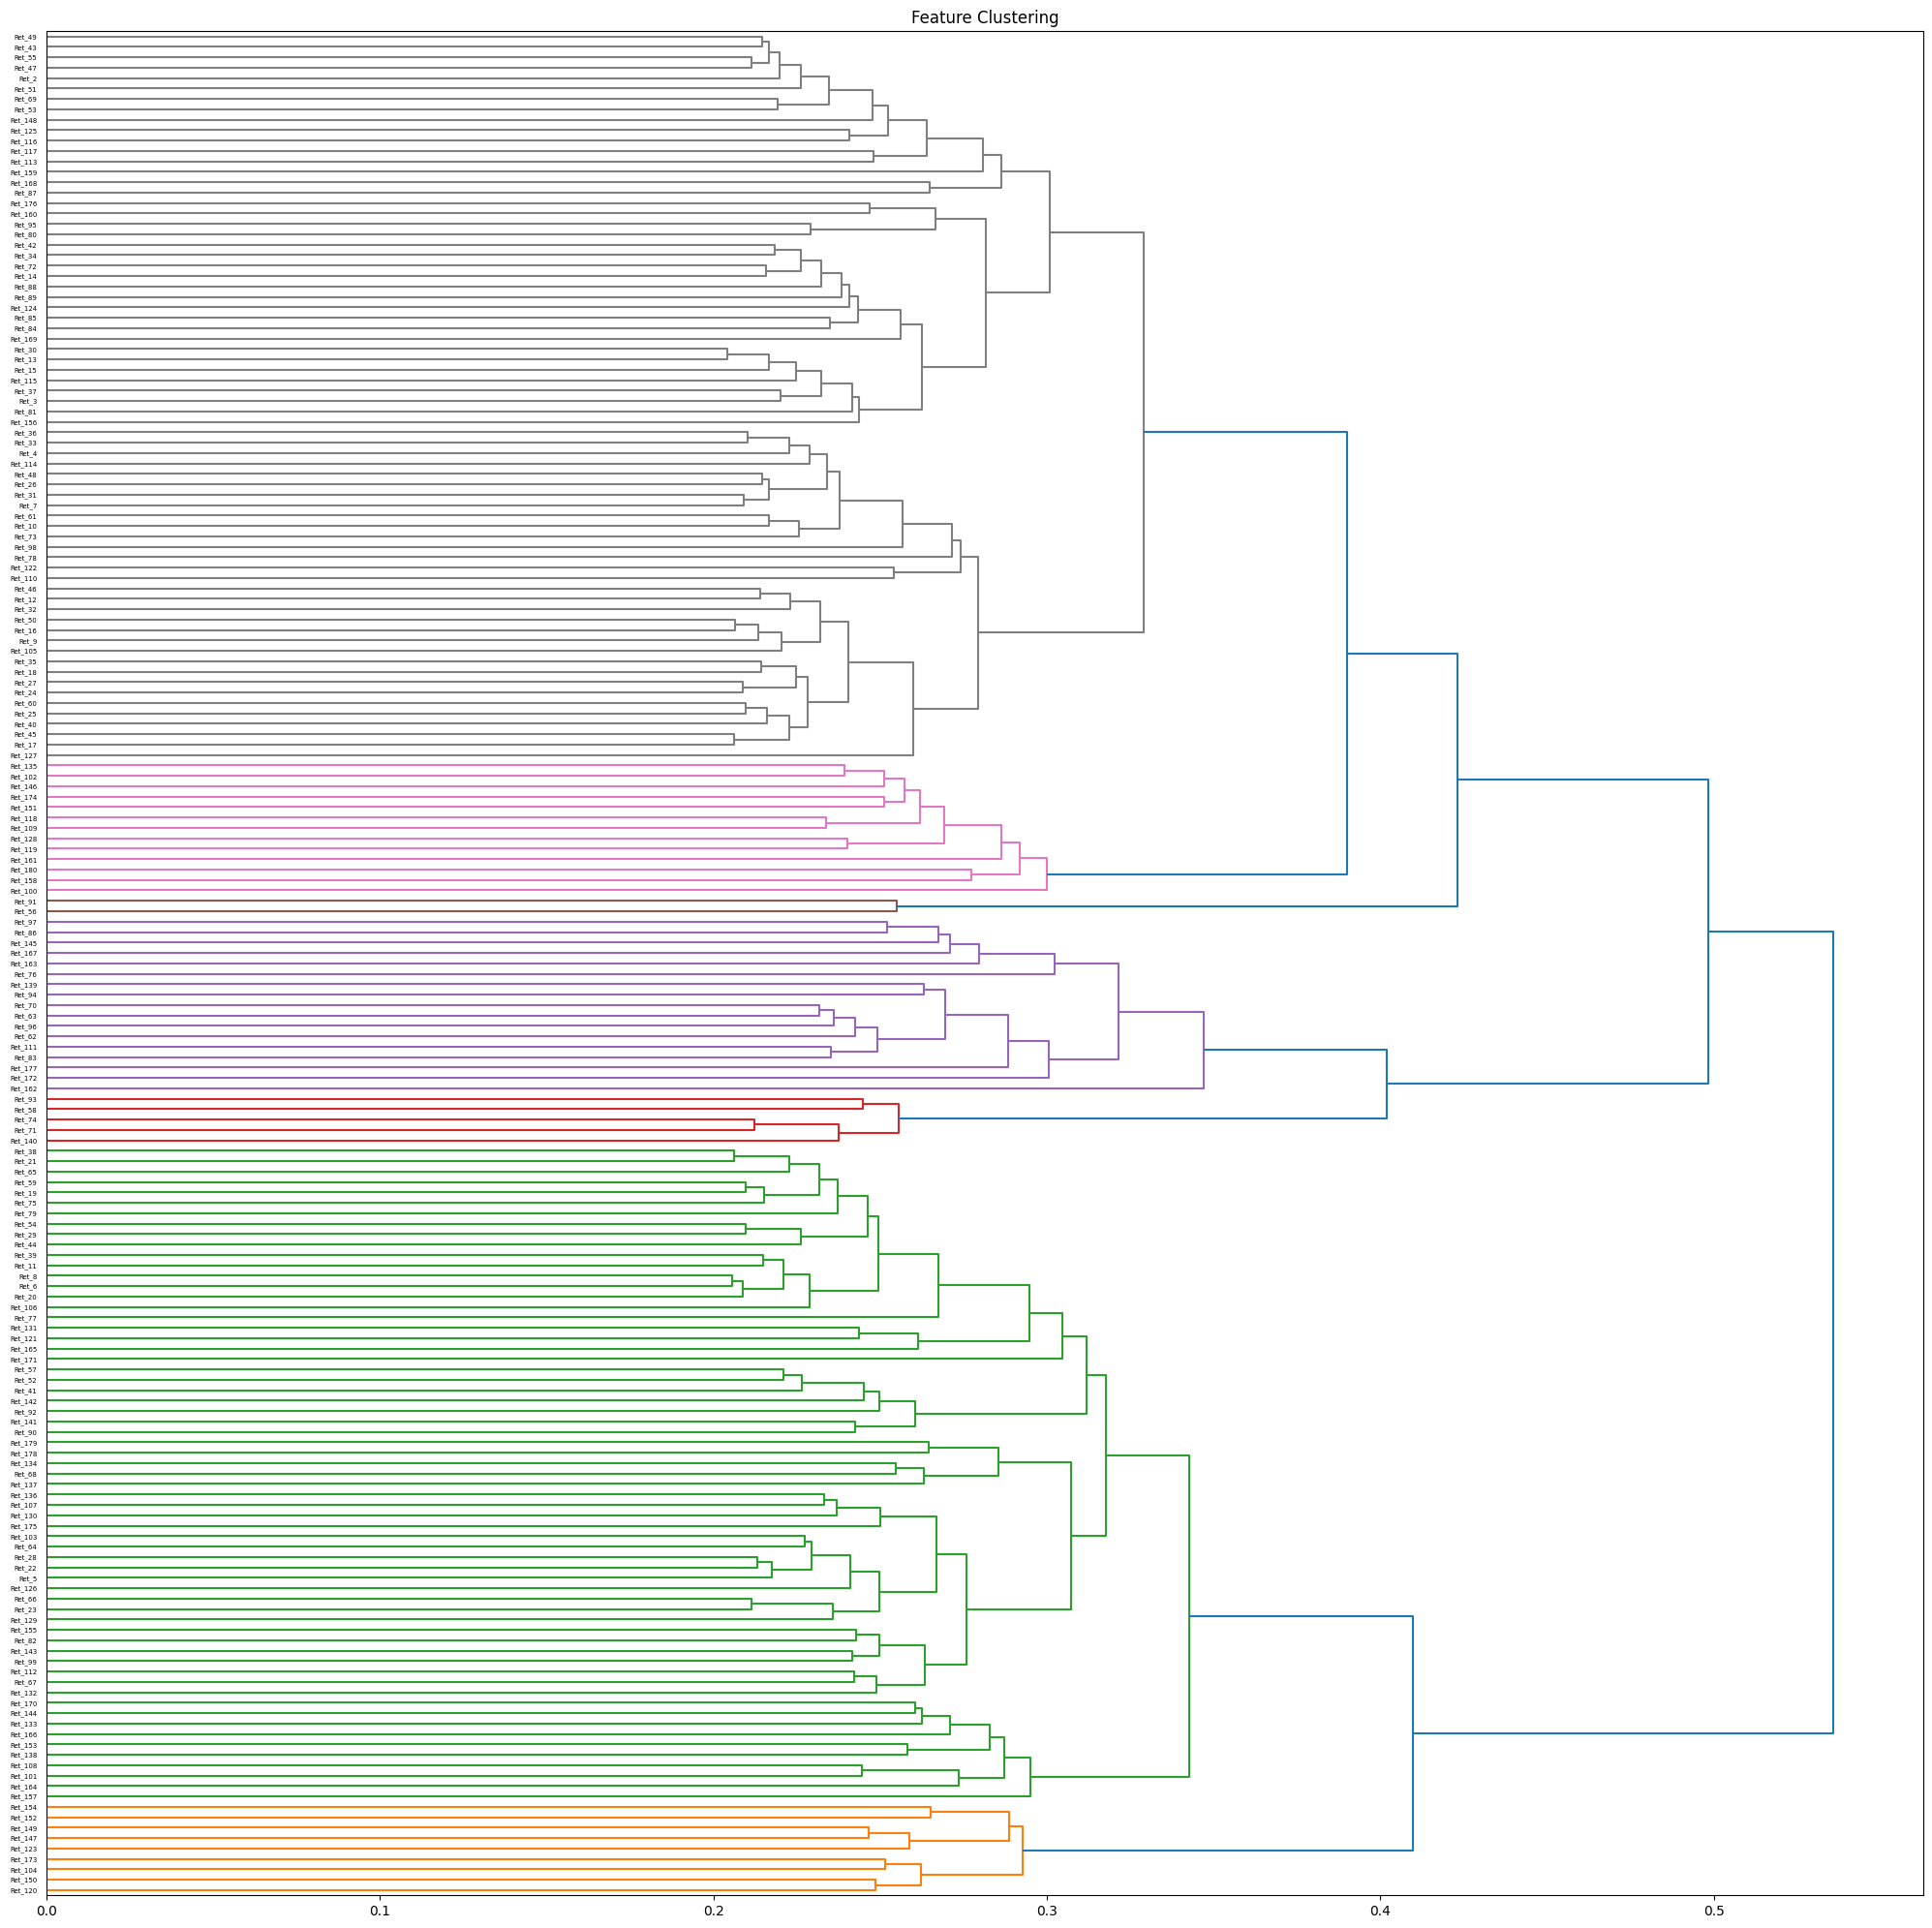

In [88]:
Z = linkage(df[intra_ret_cols].dropna().T, 'ward')
fig, ax = plt.subplots(figsize=(25,25))
dendrogram(Z, labels=intra_ret_cols, orientation='right')
plt.title('Feature Clustering')
plt.show()

**Data Preparation**

Handling missing values

In [95]:
df = df_copy.copy()

In [96]:
df.isnull().sum().sort_values(ascending=False)

Feature_1         33313
Feature_10        19471
Feature_2          9146
Feature_20         7826
Feature_4          7721
                  ...  
Ret_137               0
Ret_136               0
Ret_135               0
Ret_134               0
log_volatility        0
Length: 212, dtype: int64

Features 2, 10 and 2 will be dropped because 1 & 10 have high amounts of missing data, likewise 2 but with the addition of the insight that feature 7 holds similar data representation to it, hence reducing redundancy

In [102]:
df.drop(['Feature_2', 'Feature_10', 'Feature_1'], axis=1, inplace=True)

In [103]:
new_feature_cols = [f"Feature_{i}" for i in range(1, 26) if i not in [2, 10, 1]]

In [104]:
df.loc[:,new_feature_cols].isnull().sum().sort_values(ascending=False)

Feature_20    7826
Feature_4     7721
Feature_15    2141
Feature_6     1933
Feature_9     1875
Feature_23    1711
Feature_22    1345
Feature_3     1237
Feature_19    1190
Feature_12    1096
Feature_21    1018
Feature_11     987
Feature_14     728
Feature_24     726
Feature_25     655
Feature_17     646
Feature_16     610
Feature_13     594
Feature_18     568
Feature_8      469
Feature_7        0
Feature_5        0
dtype: int64

In [105]:
feature_imputer = Imputer(method="mean")

In [106]:
df[new_feature_cols] = feature_imputer.fit_transform(df.loc[:, new_feature_cols])

In [107]:
df.loc[:,intra_ret_feat_cols].isnull().sum().sort_values(ascending=False)

Ret_16     1402
Ret_26     1392
Ret_25     1384
Ret_29     1376
Ret_11     1369
           ... 
Ret_102     499
Ret_117     472
Ret_112     462
Ret_92      440
Ret_120       0
Length: 119, dtype: int64

In [108]:
print(df.loc[:,intra_ret_feat_cols].isnull().sum().sum())

112461


In [109]:
# Forward-fill and Backward-fill all intraday columns across rows (horizontally)
df[intra_ret_feat_cols] = df[intra_ret_feat_cols].fillna(method='ffill', axis=1)
df[intra_ret_feat_cols] = df[intra_ret_feat_cols].fillna(method='bfill', axis=1)

In [110]:
df.loc[:,intra_ret_feat_cols].isnull().sum().sort_values(ascending=False)

Ret_2      0
Ret_77     0
Ret_89     0
Ret_88     0
Ret_87     0
          ..
Ret_37     0
Ret_36     0
Ret_35     0
Ret_34     0
Ret_120    0
Length: 119, dtype: int64

In [111]:
print(df.loc[:,intra_ret_feat_cols].isnull().sum().sum())

0


Handling Outliers

In [113]:
Q1 = df[intra_ret_feat_cols].quantile(0.25)
Q3 = df[intra_ret_feat_cols].quantile(0.75)
IQR = Q3 - Q1

# Define outliers using 1.5*IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((df[intra_ret_feat_cols] < lower_bound) | (df[intra_ret_feat_cols] > upper_bound)).sum().sort_values(ascending=False)/len(df) *100
print(f'Percentage of Outliers\n {outliers}')

Percentage of Outliers
 Ret_95     10.7475
Ret_109    10.6600
Ret_108    10.6525
Ret_86     10.6200
Ret_77     10.5650
            ...   
Ret_72      9.4625
Ret_47      9.4150
Ret_42      9.3800
Ret_30      9.3275
Ret_63      9.3225
Length: 119, dtype: float64


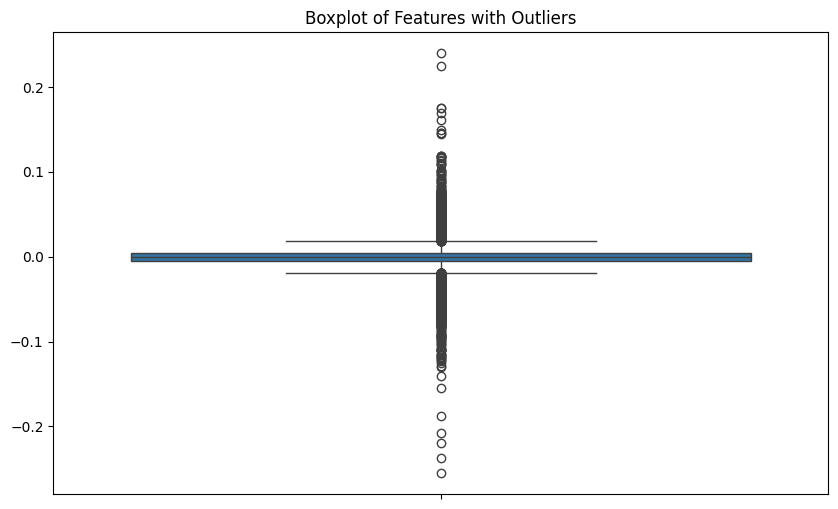

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=intraday_cumsum)
plt.title("Boxplot of Features with Outliers")
plt.show()

Due to insufficient insight on data quality and context to events surrounding the data we cannot tell if the outliers are representative of noise or market spice. But due to the information from autocorrelation and the skewdness indicating low volatility, outliers would be capped.

Feature Engineering

In [119]:
# Rolling RSI (row-wise)
def compute_rsi_row(data, period=14):
    delta = data.diff(axis=1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    # min_periods=1 is set to ignore nan values in a given window when calculating mean
    avg_gain = gain.rolling(window=period, min_periods=1, axis=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1, axis=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [127]:
# Rolling Volatility (row-wise)
df['Volatility_60'] = df[intra_ret_feat_cols].iloc[:, :60].std(axis=1)
df['Volatility_120'] = df[intra_ret_feat_cols].iloc[:, 60:120].std(axis=1)

# Compute RSI for Ret_1 to Ret_60
rsi_1_to_60 = compute_rsi_row(df[intra_ret_feat_cols].iloc[:, :60], period=14)
df['RSI_60'] = rsi_1_to_60.iloc[:, -1]  # Take the last RSI value from the rolling window to indicate final momentum for selected time slot

# Compute RSI for Ret_61 to Ret_120
rsi_61_to_120 = compute_rsi_row(df[intra_ret_feat_cols].iloc[:, 60:120], period=14)
df['RSI_61_120'] = rsi_61_to_120.iloc[:, -1]  # Take the last RSI value from the rolling window to indicate final momentum for selected time slot

In [128]:
display_all_columns(df.head())

Id  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  \
0   1   0.558392   0.405572        8.0   0.430972      75751     0.2254   
1   2   0.558392   0.405572        3.0   0.388896      17369     0.0166   
2   3   0.739591  -0.167928        9.0   0.471947       8277     0.3650   
3   4   1.568248   0.479073        5.0   0.120653      22508     0.2654   
4   5   2.765531   1.245280        7.0   4.866985      22423     0.2138   

   Feature_9  Feature_11  Feature_12  Feature_13  Feature_14  Feature_15  \
0       11.0   -0.572244        0.49         5.0    1.842984   27.053679   
1       13.0   -0.409923        0.71         9.0    1.577586    9.546915   
2        9.0   -0.473024        0.03         6.0    1.871160    9.647559   
3       13.0   -2.138383        0.00         6.0    1.588524    1.801865   
4       13.0   -4.795565        0.97         5.0    0.842102    9.198895   

   Feature_16  Feature_17  Feature_18  Feature_19  Feature_20  Feature_21  \
0         1.0   -0.549725    0.803059   -0.925463         2.0    0.605593   
1         1.0   -0.949891    0.917958   -0.897067         9.0    0.886205   
2         1.0   -1.132426    1.799813   -1.603488         3.0    0.605593   
3         1.0   -1.131213    1.565036   -1.205438         7.0    1.148738   
4         1.0    6.317498   -3.208872   -1.102189         7.0    3.381040   

   Feature_22  Feature_23  Feature_24  Feature_25  Ret_MinusTwo  Ret_MinusOne  \
0   -0.489492    0.799833   -1.209290   -0.329675      0.055275     -0.010770   
1   -0.151805    1.239856    0.953424   -0.709462      0.009748      0.002987   
2    0.389061    1.728096   -1.798090   -1.019370      0.003077      0.006181   
3   -2.440799    1.551425   -1.788725   -0.329675      0.000984      0.014106   
4    1.732708    1.965189   -5.993092    3.219820     -0.018224      0.011065   

      Ret_2     Ret_3     Ret_4     Ret_5     Ret_6     Ret_7     Ret_8  \
0  0.000003 -0.000734 -0.000738 -0.000007  0.000423  0.000438 -0.000076   
1 -0.000487  0.000475  0.000002 -0.000002 -0.000523 -0.000255 -0.000008   
2 -0.000782 -0.000402  0.000807  0.000400  0.000656 -0.001177  0.001198   
3  0.000277 -0.000088 -0.000199 -0.000301  0.000711 -0.000431 -0.000144   
4 -0.001232  0.000002 -0.001205 -0.000021  0.000005  0.000623 -0.001843   

      Ret_9    Ret_10    Ret_11    Ret_12    Ret_13    Ret_14    Ret_15  \
0  0.000645 -0.000006  0.000006  0.000006 -0.000156 -0.000156 -0.000156   
1  0.000048 -0.000312 -0.000742 -0.000009 -0.000248  0.000487  0.000256   
2  0.000610 -0.001031  0.000647 -0.000930 -0.000543  0.000663  0.000787   
3  0.000340 -0.000639  0.000420  0.000145 -0.000130  0.000589  0.000410   
4  0.000005  0.001226  0.001213 -0.002428  0.000974  0.000249 -0.001217   

     Ret_16        Ret_17    Ret_18    Ret_19    Ret_20    Ret_21  \
0 -0.000430 -1.964625e-05  0.000002 -0.000031 -0.000031 -0.000031   
1 -0.000508  2.495416e-04  0.000015  0.000008 -0.000251 -0.000519   
2  0.000390  1.348995e-04  0.000122 -0.000133  0.000003  0.000141   
3  0.000134  6.039066e-07 -0.000266  0.000071 -0.000058 -0.000710   
4  0.001220  2.388634e-05 -0.000017 -0.001246  0.001220 -0.000006   

         Ret_22    Ret_23    Ret_24    Ret_25    Ret_26    Ret_27    Ret_28  \
0 -7.539950e-06 -0.000008  0.000416 -0.000164 -0.000009 -0.000438 -0.000438   
1 -5.029784e-04  0.000240  0.000248  0.000495 -0.000243 -0.000252 -0.000252   
2  5.381418e-04  0.000532  0.000106  0.000106 -0.000261  0.000125 -0.000268   
3  2.851906e-04 -0.000141  0.000003  0.000281  0.000012  0.000001 -0.000291   
4  4.624901e-07 -0.001222 -0.000001  0.001228  0.001220 -0.001213  0.001218   

     Ret_29        Ret_30    Ret_31    Ret_32    Ret_33    Ret_34    Ret_35  \
0  0.000010 -7.176461e-04 -0.000162 -0.000162 -0.000162 -0.000162 -0.000582   
1 -0.000230  2.122038e-04 -0.000503 -0.000014 -0.000008  0.000241  0.000017   
2 -0.000404 -7.805902e-04  0.000270 -0.000399 -0.000388  0.000025 -0.000500   
3  0.000003 -9.865118e-07 -0.000283  

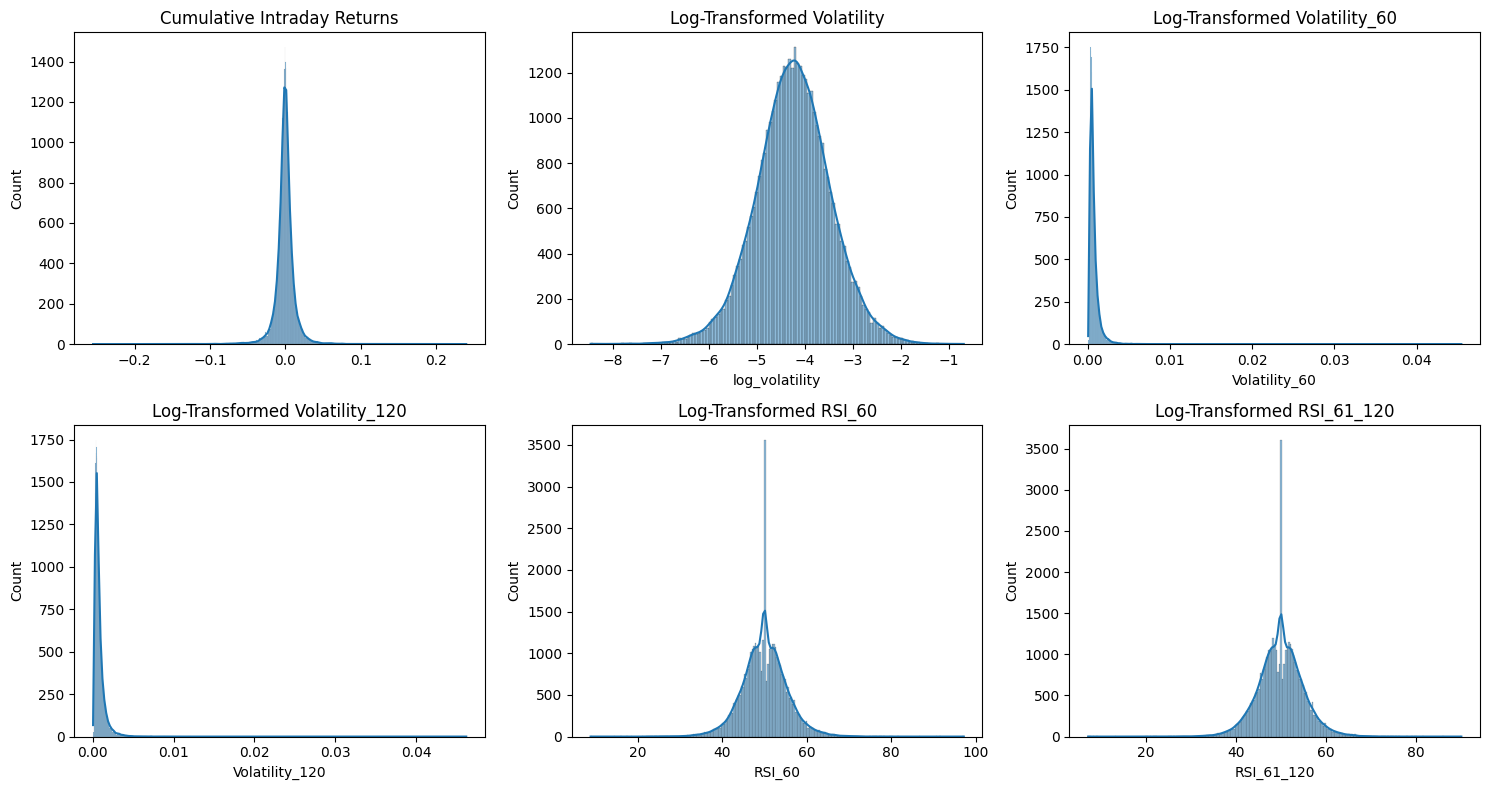

In [129]:
fig,ax = plt.subplots(2,3, figsize=(15, 8))

ax = ax.ravel()

sns.histplot(intraday_cumsum, kde=True, ax=ax[0])
ax[0].set_title('Cumulative Intraday Returns')

sns.histplot(df['log_volatility'], kde=True, ax=ax[1])
ax[1].set_title('Log-Transformed Volatility')

sns.histplot(df['Volatility_60'], kde=True, ax=ax[2])
ax[2].set_title('Log-Transformed Volatility_60')

sns.histplot(df['Volatility_120'], kde=True, ax=ax[3])
ax[3].set_title('Log-Transformed Volatility_120')

sns.histplot(df['RSI_60'], kde=True, ax=ax[4])
ax[4].set_title('Log-Transformed RSI_60')

sns.histplot(df['RSI_61_120'], kde=True, ax=ax[5])
ax[5].set_title('Log-Transformed RSI_61_120')

plt.tight_layout()
plt.show()

In [130]:
new_features = ['Volatility_60',	'Volatility_120',	'RSI_60',	'RSI_61_120']

In [433]:
model_train = df.drop(intra_ret_target_cols+['log_volatility'], axis=1)

weights = model_train.loc[:,['Id','Weight_Daily','Weight_Intraday']]

model_train.drop(['Weight_Daily','Weight_Intraday','Ret_PlusOne','Ret_PlusTwo'],axis=1, inplace=True)
targets = df[intra_ret_target_cols+inter_ret_target_cols]

scaler = StandardScaler()
scaled_train = pd.DataFrame(scaler.fit_transform(model_train), columns=model_train.columns)

**Intraday Modelling**

In [461]:
#Defining intraday data for modelling
y_intra = targets[intra_ret_target_cols]
X_intra = scaled_train.copy()

In [463]:
X_train, X_test, y_train, y_test = train_test_split(X_intra, y_intra, test_size=0.2, random_state=16)

In [465]:
kfold = KFold(n_splits=5, shuffle=True, random_state=16)
xgb_intra_model = xgb.XGBRegressor(random_state=16, objective='reg:squarederror', n_jobs=-1, verbosity=0)
params = {'max_depth':[3,5,7,11],
          'learning_rate':[0.01,0.05,0.1,0.15],
          'n_estimators':[100,150,200,250],
          'colsample_bytree':[0.3,0.5,0.7],
          'min_child_weight':[3,5,7]}
grid_intra = RandomizedSearchCV(xgb_intra_model, params, cv=kfold, scoring='neg_mean_squared_error')
grid_intra.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=16, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 5, 7, 11],
                                        'min_child_weight': [3, 5, 7],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='neg_mean_squared_error')

In [466]:
grid_intra.best_params_

{'n_estimators': 200,
 'min_child_weight': 3,
 'max_depth': 11,
 'learning_rate': 0.05,
 'colsample_bytree': 0.3}

In [467]:
grid_intra.best_score_

-1.2014373493280788e-06

In [468]:
predictions_intra = grid_intra.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, predictions_intra)}\nMean Absolute Error: {mean_absolute_error(y_test, predictions_intra)}')

Mean Squared Error: 1.040634860688834e-06
Mean Absolute Error: 0.0005991325888328234


**Interday Modelling**

In [435]:
#Defining interday data for modelling
y_inter = targets[inter_ret_target_cols]
X_inter = scaled_train.copy()

In [437]:
X_train, X_test, y_train, y_test = train_test_split(X_inter, y_inter, test_size=0.2, random_state=16)

In [439]:
kfold = KFold(n_splits=5, shuffle=True, random_state=16)
xgb_inter_model = xgb.XGBRegressor(random_state=16, objective='reg:squarederror', n_jobs=-1, verbosity=0)
params = {'max_depth':[3,5,7,11],
          'learning_rate':[0.01,0.05,0.1,0.15],
          'n_estimators':[100,150,200,250],
          'colsample_bytree':[0.3,0.5,0.7],
          'min_child_weight':[3,5,7]}

grid_inter = RandomizedSearchCV(xgb_inter_model, params, cv=kfold, scoring='neg_mean_squared_error')
grid_inter.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=16, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None,
                                          random_state=16, ...),
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'learning_rate': [0.01, 0.05, 0.1,
                                                          0.15],
                                        'max_depth': [3, 5, 7, 11],
                                        'min_child_weight': [3, 5, 7],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='neg_mean_squared_error')

In [441]:
grid_inter.best_params_

{'n_estimators': 250,
 'min_child_weight': 3,
 'max_depth': 11,
 'learning_rate': 0.05,
 'colsample_bytree': 0.3}

In [443]:
grid_inter.best_score_

-0.0005082622293286933

In [445]:
predictions_inter = grid_inter.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, predictions_inter)}\nMean Absolute Error: {mean_absolute_error(y_test, predictions_inter)}')

Mean Squared Error: 0.0005153488732918222
Mean Absolute Error: 0.01431182631730716


##### Evaluating with weights

In [308]:
weights.head()

Id  Weight_Daily  Weight_Intraday
0   1  1.564385e+06     1.251508e+06
1   2  2.167438e+06     1.733950e+06
2   3  1.911497e+06     1.529197e+06
3   4  2.139462e+06     1.711569e+06
4   5  1.584088e+06     1.267270e+06

In [310]:
X_test.head()

Id  Feature_3     Feature_4  Feature_5     Feature_6  Feature_7  \
28243  0.713908  -0.249550 -7.695344e-02   0.515662 -4.231872e-01  -0.508850   
16167 -0.331904  -0.988031 -2.618342e+00   0.515662 -7.389692e-01  -1.420646   
27341  0.635793  -1.795894 -7.733308e-17  -1.523568 -3.469856e-01  -1.188298   
4962  -1.302286  -0.005210  1.050244e+00  -1.183697 -1.569395e-01   1.259152   
10170 -0.851260   1.010021  1.047054e+00   0.855533 -1.139388e-16   0.153354   

       Feature_8  Feature_9  Feature_11  Feature_12  ...   Ret_116   Ret_117  \
28243  -1.352940   0.474207    0.196990   -1.379001  ... -0.210493  0.332449   
16167   1.220622  -0.963099    0.697500   -0.744989  ... -0.252428 -0.724395   
27341   1.052102  -0.244446    1.284204    1.358780  ...  0.440111  1.084983   
4962    0.738306  -0.603772    0.479377   -0.629714  ... -0.026945  0.011975   
10170   0.979464  -1.322425    0.491292   -1.379001  ...  1.434635  0.959969   

        Ret_118   Ret_119   Ret_120  log_volatility  Volatility_60  \
28243  0.031653 -0.010585  0.844945        0.947488       0.300873   
16167 -0.786204 -0.796782 -0.180542       -0.289802       0.156119   
27341  0.273192 -1.411531  0.658998       -1.759189      -0.347456   
4962   0.436206  0.003697  0.006454       -0.775982      -0.299663   
10170  1.597948  1.180380  0.416457        0.581843       0.888077   

       Volatility_120    RSI_60  RSI_61_120  
28243        0.443194  0.371411    1.334613  
16167       -0.242418  0.076407   -1.079104  
27341       -0.374206  1.324917    0.428914  
4962        -0.454300  0.507180   -0.519943  
10170        0.799516 -1.505598    0.256989  

[5 rows x 149 columns]

In [370]:
weight_data = X_test.join(weights.drop('Id', axis=1), how='left')

In [372]:
weight_data.shape

(8000, 151)

In [374]:
weight_data.head()

Id  Feature_3     Feature_4  Feature_5     Feature_6  Feature_7  \
28243  0.713908  -0.249550 -7.695344e-02   0.515662 -4.231872e-01  -0.508850   
16167 -0.331904  -0.988031 -2.618342e+00   0.515662 -7.389692e-01  -1.420646   
27341  0.635793  -1.795894 -7.733308e-17  -1.523568 -3.469856e-01  -1.188298   
4962  -1.302286  -0.005210  1.050244e+00  -1.183697 -1.569395e-01   1.259152   
10170 -0.851260   1.010021  1.047054e+00   0.855533 -1.139388e-16   0.153354   

       Feature_8  Feature_9  Feature_11  Feature_12  ...   Ret_118   Ret_119  \
28243  -1.352940   0.474207    0.196990   -1.379001  ...  0.031653 -0.010585   
16167   1.220622  -0.963099    0.697500   -0.744989  ... -0.786204 -0.796782   
27341   1.052102  -0.244446    1.284204    1.358780  ...  0.273192 -1.411531   
4962    0.738306  -0.603772    0.479377   -0.629714  ...  0.436206  0.003697   
10170   0.979464  -1.322425    0.491292   -1.379001  ...  1.597948  1.180380   

        Ret_120  log_volatility  Volatility_60  Volatility_120    RSI_60  \
28243  0.844945        0.947488       0.300873        0.443194  0.371411   
16167 -0.180542       -0.289802       0.156119       -0.242418  0.076407   
27341  0.658998       -1.759189      -0.347456       -0.374206  1.324917   
4962   0.006454       -0.775982      -0.299663       -0.454300  0.507180   
10170  0.416457        0.581843       0.888077        0.799516 -1.505598   

       RSI_61_120  Weight_Daily  Weight_Intraday  
28243    1.334613  1.642733e+06     1.314187e+06  
16167   -1.079104  1.757974e+06     1.406380e+06  
27341    0.428914  2.149891e+06     1.719912e+06  
4962    -0.519943  1.968456e+06     1.574765e+06  
10170    0.256989  1.480207e+06     1.184166e+06  

[5 rows x 151 columns]

In [380]:
X_test.shape, weights.shape, weight_data.shape, predictions_inter.shape

((8000, 149), (40000, 3), (8000, 151), (8000, 2))

In [404]:
predictions_inter[:,1]

array([ 0.00493782, -0.00169418,  0.00117622, ..., -0.00556999,
       -0.00207474,  0.00436308], dtype=float32)

In [447]:
interday_absolute_errors_1 = (y_test.values[:,0] - predictions_inter[:,0])
weighted_interday_errors_1 = weight_data['Weight_Daily'].values*interday_absolute_errors_1
wmae_interday_ret1 = weighted_interday_errors_1.sum()/weight_data['Weight_Daily'].sum()

interday_absolute_errors_2 = (y_test.values[:,1] - predictions_inter[:,1])
weighted_interday_errors_2 = weight_data['Weight_Daily'].values*interday_absolute_errors_2
wmae_interday_ret2 = weighted_interday_errors_2.sum()/weight_data['Weight_Daily'].sum()

In [449]:
wmae_interday_ret1, wmae_interday_ret2

(0.0002271118628741224, 7.312845798879062e-05)

In [507]:
submission = pd.read_csv('sample_submission_2.csv')

In [412]:
test.columns

Index(['Id', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7',
       'Feature_8', 'Feature_9', 'Feature_11', 'Feature_12',
       ...
       'Ret_115', 'Ret_116', 'Ret_117', 'Ret_118', 'Ret_119', 'Ret_120',
       'Volatility_60', 'Volatility_120', 'RSI_60', 'RSI_61_120'],
      dtype='object', length=148)

In [429]:
inter_ret_cols

['Ret_MinusTwo', 'Ret_MinusOne', 'Ret_PlusOne', 'Ret_PlusTwo']

In [455]:
# Preparing the test dataset

# dropping redundant features
test.drop(['Feature_2', 'Feature_10', 'Feature_1'], axis=1, inplace=True)
test[new_feature_cols] = feature_imputer.fit_transform(test.loc[:, new_feature_cols])
test[intra_ret_feat_cols] = test[intra_ret_feat_cols].fillna(method='ffill', axis=1)
test[intra_ret_feat_cols] = test[intra_ret_feat_cols].fillna(method='bfill', axis=1)

# Dealing with outliers
test_Q1 = test[intra_ret_feat_cols].quantile(0.25)
test_Q3 = test[intra_ret_feat_cols].quantile(0.75)
test_IQR = test_Q3 - test_Q1

test_lower_bound = test_Q1 - 1.5 * test_IQR
test_upper_bound = test_Q3 + 1.5 * test_IQR

for col in intra_ret_feat_cols:
  test[col] = test[col].clip(lower=test_lower_bound[col], upper=test_upper_bound[col])

# Test feature engineering
test['Volatility_60'] = test[intra_ret_feat_cols].iloc[:, :60].std(axis=1)
test['Volatility_120'] = test[intra_ret_feat_cols].iloc[:, 60:120].std(axis=1)
rsi_1_to_60 = compute_rsi_row(test[intra_ret_feat_cols].iloc[:, :60], period=14)
test['RSI_60'] = rsi_1_to_60.iloc[:, -1]  # Take the last RSI value from the rolling window to indicate final momentum for selected time slot
rsi_61_to_120 = compute_rsi_row(test[intra_ret_feat_cols].iloc[:, 60:120], period=14)
test['RSI_61_120'] = rsi_61_to_120.iloc[:, -1]  # Take the last RSI value from the rolling window to indicate final momentum for selected time slot

In [417]:
X_inter.shape, test.shape

((40000, 149), (120000, 148))

In [419]:
test.head()

Id  Feature_3  Feature_4  Feature_5  Feature_6  Feature_7  Feature_8  \
0   1  -0.056284   0.407434       10.0   0.413226      18871     0.2138   
1   2   0.907973   1.002425        7.0  -0.257825       5852     0.2138   
2   3   1.076668   0.517865        5.0   0.947340      76935     0.0105   
3   4   0.223222   0.407434        1.0   0.439345      84573     0.3318   
4   5   0.597896  -0.145497       10.0   0.275744      89615     0.0099   

   Feature_9  Feature_11  Feature_12  ...   Ret_115   Ret_116   Ret_117  \
0       11.0   -0.229910        0.97  ... -0.001307 -0.001301 -0.000917   
1       13.0   -0.971909        0.93  ... -0.000012 -0.000463 -0.000003   
2       10.0   -1.096276        0.88  ...  0.000003  0.000164  0.000353   
3       13.0   -0.509942        0.76  ...  0.000170 -0.001079  0.000320   
4        8.0   -1.188949        0.64  ...  0.000057 -0.000050 -0.000011   

    Ret_118   Ret_119   Ret_120  Volatility_60  Volatility_120     RSI_60  \
0  0.000762 -0.000556  0.000759       0.000572        0.000666  51.446564   
1 -0.000002  0.000468 -0.000012       0.000532        0.000506  46.120234   
2  0.000704 -0.000168 -0.000006       0.000454        0.000331  45.444103   
3  0.000006  0.001347 -0.001336       0.000445        0.000605  57.457810   
4 -0.000377  0.000227 -0.000114       0.000291        0.000349  49.909929   

   RSI_61_120  
0   50.004502  
1   41.871820  
2   46.147074  
3   43.204239  
4   40.358389  

[5 rows x 148 columns]

In [421]:
X_inter.head()

Id     Feature_3     Feature_4  Feature_5     Feature_6  Feature_7  \
0 -1.732008  2.500048e-16 -7.733308e-17   0.855533 -1.139388e-16   0.938530   
1 -1.731921  2.500048e-16 -7.733308e-17  -0.843825 -2.878706e-02  -1.128670   
2 -1.731834  2.040150e-01 -7.989477e-01   1.195405  2.803427e-02  -1.450602   
3 -1.731748  1.137018e+00  1.023955e-01  -0.164082 -2.123138e-01  -0.946708   
4 -1.731661  2.485065e+00  1.169805e+00   0.515662  3.035030e+00  -0.949717   

   Feature_8  Feature_9    Feature_11  Feature_12  ...   Ret_116   Ret_117  \
0   0.206597   0.114881 -9.019906e-17   -0.024520  ... -0.999866  0.005232   
1  -1.310083   0.833534  1.318770e-01    0.609492  ... -0.276411 -0.300850   
2   1.220622  -0.603772  8.061042e-02   -1.350183  ... -0.256944 -0.436299   
3   0.497148   0.833534 -1.272395e+00   -1.436639  ...  0.310604 -0.357657   
4   0.122337   0.833534 -3.431198e+00    1.358780  ... -0.020954 -1.013161   

    Ret_118   Ret_119   Ret_120  log_volatility  Volatility_60  \
0 -0.098407 -0.021035  0.112774        1.147016      -0.423828   
1 -0.086883 -0.018882  0.213599       -0.673576      -0.600624   
2 -0.587927 -0.253817 -0.306288        0.248635      -0.293818   
3 -0.609390  0.123491  0.185636       -0.655119      -0.703504   
4  0.025784  1.064045  0.001354        0.891227       0.143307   

   Volatility_120    RSI_60  RSI_61_120  
0        0.248562  0.949479    0.187521  
1       -0.571635 -1.657173    1.465856  
2       -0.409789 -0.958778   -0.493126  
3       -0.680023  0.437354    0.932894  
4        0.044036  0.000684   -0.014146  

[5 rows x 149 columns]

In [457]:
interday_test_predictions = grid_inter.predict(test)

In [469]:
intraday_test_predictions = grid_intra.predict(test)

In [475]:
interday_test_predictions.shape

(120000, 2)

In [477]:
intraday_test_predictions.shape

(120000, 60)

In [483]:
combined_predictions = np.hstack([intraday_test_predictions,interday_test_predictions])
stacked_predictions = combined_predictions.reshape(-1,1)

In [485]:
stacked_predictions.shape

(7440000, 1)

In [487]:
submission.shape

(7440000, 2)

In [489]:
my_submission = submission.copy()

In [491]:
my_submission.head()

Id  Predicted
0  1_1          0
1  1_2          0
2  1_3          0
3  1_4          0
4  1_5          0

In [493]:
my_submission['Predicted'] = stacked_predictions

In [501]:
my_submission.head()

Id  Predicted
0  1_1  -0.000125
1  1_2   0.000040
2  1_3  -0.000051
3  1_4  -0.000053
4  1_5  -0.000044

In [499]:
submission.head()

Id  Predicted
0  1_1          0
1  1_2          0
2  1_3          0
3  1_4          0
4  1_5          0

In [513]:
submission.columns

Index(['Id', 'Predicted'], dtype='object')

In [515]:
my_submission.columns

Index(['Id', 'Predicted'], dtype='object')

In [517]:
submission.shape, my_submission.shape

((7440000, 2), (7440000, 2))

In [523]:
my_submission.to_csv('emmanuel_wsc_submission.csv', index=False)

In [525]:
checking = pd.read_csv('emmanuel_wsc_submission.csv')

In [526]:
checking.head()

Id  Predicted
0  1_1  -0.000125
1  1_2   0.000040
2  1_3  -0.000051
3  1_4  -0.000053
4  1_5  -0.000044